# Toronto Community Health Profiling by Cluster Analysis #
This is pilot data science portfolio to cluster neighborhoods within the City of Toronto using socio-economic-health indicators.
The dataset was compiled and sourced from Ontario Community Health Profiles Partnership website. The page can be found here (http://www.ontariohealthprofiles.ca/).

The dataset is a collection of indicators from multiple data sources to describe the Toronto community health profile at a  neighborhood level. These indicators are categorized by 10 different categories which include population, socio-demographic, language, marginalization index, primary care, emergency care, hospital admissions, adult health, prevention, injuries, palliative care and birth rate.

**Problem Statement**: members of government agencies in Toronto Local Health Integration Network (TC LHIN), Minisitry of Health (MoH) and City of Toronto are interested in profiling the community health across Toronto at a neighborhood level. Basically, this will help them to establish the strategic plan for appropriate resource allocation (i.e., to reduce the potential gap between different social-income classes).

**Potential Stakeholders**:
* Members from Ministry of Health and Long-term Care (MoHLTC)
* Members from Toronto Local Health Integration Network (TC LHIN)
* Members from Public Health Ontario (PHO)
* Members from City of Toronto

**Goal**: to provide the community health comparison standards which are segemented at neighborhood level. Unlike hospital service providers (i.e., university teaching, pediatric, mental health), there is no clear peer group comparison standard established for community health service providers. Thus, we want to establish the community health profile segmenation across the City of Toronto.

**Future Work**:
* Collection of meaningful features - age group, education level, employment level, etc.
* Other models: Gaussian Mixtures, K-Medioids, etc.
* Other feature scalers: Log scaler, Min-Max scaler.

**Recommendation for Clients**:

1) Neighborhood identity & positioning strategy
* Make the link between segmeneted neighborhood group association and household's behavior (income, health determinants)

2) Marketing effectiveness
* Assess the household's behaviors (i.e., service usage/visits) to identify the bottle neck
* Optimize the resource planning investment on the most demand neighborhoods (i.e., poor, high hospital visits, etc.)

3) Neighborhood Segmentation Framework - Evaluation
* Evaluate the current vs. future state for peer group comparison at a neighborhood level
* Identify area(s) that are not meeting the needs or demands (i.e., low income, high prevalence of chronic conditions, etc.)

In [1]:
# Import all libraries:
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn:
sns.set_style('whitegrid')
#sns.set_context('poster')

## Data Loading ##
The dataset consists of information on various community health profile at a neighborhood level across Toronto area. The types of features include but not limited to 10 different types of indicator sources (i.e., population, socio-demographics, primary care, emergency care, adult health disease and etc.).

In [2]:
# Load training data: 
df = pd.read_excel('ochpp_train.xlsx', sheet_name='train')
# Map column names to lowercases
df.columns = map(str.lower, df.columns)

# Check the dataframe: n_observations, data types, missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 49 columns):
nh_id                             140 non-null int64
nh_name                           140 non-null object
ward_id                           140 non-null int64
ward_name                         140 non-null object
demo_pct_males                    140 non-null float64
demo_pct_females                  140 non-null float64
inc_pct_lico_at                   140 non-null float64
inc_pct_lim_at                    140 non-null float64
inc_avg_fam_size                  140 non-null float64
inc_pct_econ_no_child             140 non-null float64
inc_pct_econ_w_child              140 non-null float64
inc_pct_lone_parents              140 non-null float64
inc_pct_one_person_house          140 non-null float64
inc_pct_2more_person_house        140 non-null float64
demo_most_sponken_lang            140 non-null object
demo_pct_eng_speakers             140 non-null float64
demo_pct_fra_speakers 

In [3]:
# Check the dataframe observations:
df.head()

,nh_id,nh_name,ward_id,ward_name,demo_pct_males,demo_pct_females,inc_pct_lico_at,inc_pct_lim_at,inc_avg_fam_size,inc_pct_econ_no_child,...,health_hosp_rate_1k,health_injury_rate_100,health_pc_mortality_rate_100,demo_birth_rate_1k,health_4_chronic_cond_rate_1k,health_diabetes_rate_100,health_asthma_rate_100,health_hbp_rate_100,health_mh_rate_100,health_copd_rate_100
0,1,West Humber-Clairville,2,Etobicoke North,0.505515,0.494485,0.137462,0.157645,3.608344,0.198630,...,151.624350,18.723404,41.509434,29.611152,14.276676,18.240313,15.880395,29.872023,7.227160,6.836167
1,2,Mount Olive-Silverstone-Jamestown,1,Etobicoke North,0.490776,0.509224,0.217822,0.278446,3.708900,0.141533,...,149.002476,18.414392,34.745763,42.018600,11.074320,18.428755,14.619216,28.466612,8.133318,6.579543
2,3,Thistletown-Beaumond Heights,1,Etobicoke North,0.495343,0.504657,0.146739,0.177866,3.450758,0.232955,...,188.338301,22.488889,48.913043,32.098765,22.447839,17.709979,15.992921,31.797739,8.447794,9.261745
3,4,Rexdale-Kipling,2,Etobicoke North,0.489285,0.510715,0.158860,0.186866,3.240506,0.227848,...,186.855555,22.595420,39.705882,32.824427,20.532592,17.458867,16.712992,31.170018,9.037934,10.466369
4,5,Elms-Old Rexdale,2,Etobicoke North,0.492390,0.507610,0.179270,0.232681,3.374749,0.208417,...,161.560976,22.525970,23.636364,36.413341,15.219512,17.028070,19.024390,28.788080,8.886524,9.702315


# Feature Transformation #
**Feature encoding** is a process where features are encoded into right data format. Oridinal feature encoding will be applied on the likert scale measures which contains information about "order/magnitude" such as likelihood (i.e., score, level, etc.). 

**Stratification** is a process where numerical features get divided into group based on the specified range(s). 

In [4]:
# Ordinal Feature Encoding #
# Define the likert scale of ON Marginalization Index Features: avg_instability_scale, ... , avg_ethnic_scale
instability_map = {1: '1-least instable', 2: '2-little instable', 
                   3: '3-neutral instable', 4: '4-somewhat instable', 5: '5-most instable'}
deprivation_map = {1: '1-least deprived', 2: '2-little deprived', 
                   3: '3-neutral deprived', 4: '4-somewhat deprived', 5: '5-most deprived'}
dependency_map = {1: '1-least dependent', 2: '2-little dependent', 
                   3: '3-neutral dependent', 4: '4-somewhat dependent', 5: '5-most dependent'}
ethnic_map = {1: '1-least ethnic concentrated', 2: '2-little ethnic concentrated', 
                   3: '3-neutral ethnic concentrated', 4: '4-somewhat ethnic concentrated', 5: '5-most ethnic concentrated'}

# Encode features with each map:
df['instability_status'] = df['mi_instability_scale'].map(instability_map)
df['deprivation_status'] = df['mi_deprivation_scale'].map(deprivation_map)
df['dependency_status'] = df['mi_dependency_scale'].map(dependency_map)
df['ethnic_status'] = df['mi_ethnic_scale'].map(ethnic_map)

# Check the encoding:
print(df['instability_status'].head())

0     1-least instable
1    2-little instable
2     1-least instable
3    2-little instable
4    2-little instable
Name: instability_status, dtype: object


In [5]:
# Stratification #
## income_bins = [50000, 60000, 70000, 80000, 90000, 100000, 110000, 120000, 130000]
## df['inc_avg_group'] = pd.cut(np.array(df['inc_avg_income']), bins=income_bins)
## print(df['inc_avg_group'].head())


# Define the bin size for grouping continuous measures:
# income_grp_bins = [54903, 78881, 102858, 126836]
lico_at_grp_bins = [0.0431, 0.1502, 0.2574, 0.3645]
ed_visits_grp_bins = [408, 677, 946, 1215]
alc_rate_grp_bins = [6, 14, 21, 28]
hosp_rate_grp_bins = [97, 129, 160, 191]
injury_rate_grp_bins = [13, 19, 25, 31]
birth_rate_grp_bins = [16, 29, 42, 55]
chronic_4_cond_rate_grp_bins = [9, 19, 28, 37]

# Generate ordinal categorical features with assigned label:
df['lico_at_grp_label'] = pd.cut(np.array(df['inc_pct_lico_at']), bins=lico_at_grp_bins, 
                                  labels=['Wealthy', 'Neutral', 'Poor'])
df['ed_visits_grp_label'] = pd.cut(np.array(df['health_unsch_ed_visits_rate_1k']), bins=ed_visits_grp_bins, 
                                  labels=['Low', 'Medium', 'High'])
df['alc_rate_grp_label'] = pd.cut(np.array(df['health_alc_rate_100']), bins=alc_rate_grp_bins, 
                                  labels=['Low', 'Medium', 'High'])
df['hosp_rate_grp_label'] = pd.cut(np.array(df['health_hosp_rate_1k']), bins=hosp_rate_grp_bins, 
                                  labels=['Low', 'Medium', 'High'])
df['injury_rate_grp_label'] = pd.cut(np.array(df['health_injury_rate_100']), bins=injury_rate_grp_bins, 
                                  labels=['Low', 'Medium', 'High'])
df['birth_rate_grp_label'] = pd.cut(np.array(df['demo_birth_rate_1k']), bins=birth_rate_grp_bins, 
                                  labels=['Low', 'Medium', 'High'])
df['chronic_4_cond_rate_grp_label'] = pd.cut(np.array(df['health_4_chronic_cond_rate_1k']), bins=chronic_4_cond_rate_grp_bins, 
                                  labels=['Low', 'Medium', 'High'])

# Check newly generated features:
print(df['lico_at_grp_label'].head())
print(df['ed_visits_grp_label'].head())

0    Wealthy
1    Neutral
2    Wealthy
3    Neutral
4    Neutral
Name: lico_at_grp_label, dtype: category
Categories (3, object): [Wealthy < Neutral < Poor]
0       Low
1    Medium
2    Medium
3    Medium
4    Medium
Name: ed_visits_grp_label, dtype: category
Categories (3, object): [Low < Medium < High]


## Data Wrangling ##
In order to feed the existing data into the K-Means clustering, we are going to transform the dataframe into a table matrix.
This table matrix contains the number of features for each neighborhood in Toronto.

In [6]:
## Data Wrangling ##
# Copy a dataframe:
df_copy = df.copy()

# Drop unnecessary columns: avoid generating irrelevant dummy variables #
df_copy = df.drop(['nh_name','ward_name','ward_id','instability_status','deprivation_status',
                   'dependency_status','ethnic_status','lico_at_grp_label','ed_visits_grp_label',
                   'alc_rate_grp_label','hosp_rate_grp_label','injury_rate_grp_label',
                   'birth_rate_grp_label','chronic_4_cond_rate_grp_label'], axis=1)

# Create a new dataframe with dummy variables:
df_new = pd.get_dummies(df_copy, drop_first=True)

# Set index: nh_id
df_new = df_new.set_index('nh_id')

# Print the new dataframe:
df_new.head()

,demo_pct_males,demo_pct_females,inc_pct_lico_at,inc_pct_lim_at,inc_avg_fam_size,inc_pct_econ_no_child,inc_pct_econ_w_child,inc_pct_lone_parents,inc_pct_one_person_house,inc_pct_2more_person_house,...,demo_most_sponken_lang_Russian,demo_most_sponken_lang_Serbian,demo_most_sponken_lang_Somali,demo_most_sponken_lang_Spanish,demo_most_sponken_lang_Tagalog,demo_most_sponken_lang_Tamil,demo_most_sponken_lang_Tibetan,demo_most_sponken_lang_Ukrainian,demo_most_sponken_lang_Urdu,demo_most_sponken_lang_Vietnamese
nh_id,,,,,,,,,,,,,,,,,,,,,
1,0.505515,0.494485,0.137462,0.157645,3.608344,0.198630,0.552927,0.197385,0.173385,0.819815,...,0,0,0,0,0,0,0,0,0,0
2,0.490776,0.509224,0.217822,0.278446,3.708900,0.141533,0.538319,0.275031,0.151316,0.846154,...,0,0,0,0,0,0,0,0,0,0
3,0.495343,0.504657,0.146739,0.177866,3.450758,0.232955,0.496212,0.229167,0.176829,0.829268,...,0,0,0,0,0,0,0,0,0,0
4,0.489285,0.510715,0.158860,0.186866,3.240506,0.227848,0.471971,0.249548,0.257812,0.747396,...,0,0,0,1,0,0,0,0,0,0
5,0.492390,0.507610,0.179270,0.232681,3.374749,0.208417,0.430862,0.320641,0.193798,0.801550,...,0,0,0,1,0,0,0,0,0,0


## Exploratory Data Analysis ##

In [7]:
# Create a separate dataframe for EDA:
df_EDA = df_new[['demo_pct_males', 'demo_pct_females', 'demo_pct_eng_speakers', 
              'demo_pct_other_lang_speakers', 'inc_pct_lico_at', 'inc_pct_econ_no_child',
              'inc_pct_econ_w_child', 'inc_pct_lone_parents', 
              'health_pct_enrolled', 'health_pct_low_continuity', 
              'health_pct_high_continuity', 'prev_pct_mammogram', 'prev_pct_paptest',
              'prev_pct_colorectal', 'prev_pct_colonoscopy', 'prev_pct_fobt',
              'inc_avg_fam_size', 'mi_instability_score', 'mi_deprivation_score',
              'mi_dependency_score', 'mi_ethnic_score', 'health_unsch_ed_visits_rate_1k',
              'health_mh_ed_visits_rate_1k', 'health_alc_rate_100', 'health_hosp_rate_1k',
              'health_injury_rate_100', 'health_pc_mortality_rate_100', 'demo_birth_rate_1k',
              'health_4_chronic_cond_rate_1k', 'health_diabetes_rate_100', 'health_asthma_rate_100',
              'health_hbp_rate_100', 'health_mh_rate_100', 'health_copd_rate_100']].copy()

# Feature Scaling: multiply by 100 on percent features
# idx: 0:15
df_EDA.iloc[:, 0:15] = df_EDA.iloc[:, 0:15] * 100

# Compute Summary Statistics #
df_stat = df_EDA.describe().T

# Re-order columns:
df_stat = df_stat[['count','std','min','mean','max','25%','50%','75%']]
# Let's look at features of interest (F.O.I): income, ED visits, birth rate, etc.
df_stat

,count,std,min,mean,max,25%,50%,75%
demo_pct_males,140.0,1.860008,44.702595,48.400589,57.984341,47.324584,48.350222,49.240604
demo_pct_females,140.0,1.860008,42.015659,51.599411,55.297405,50.759396,51.649778,52.675416
demo_pct_eng_speakers,140.0,14.107329,31.628988,72.272514,95.936688,63.595991,72.980347,83.074144
demo_pct_other_lang_speakers,140.0,14.275199,2.740373,27.038376,68.307627,16.070920,26.448165,35.561247
inc_pct_lico_at,140.0,6.741023,4.305177,16.919814,36.453084,12.855746,16.237907,20.269679
inc_pct_econ_no_child,140.0,10.416046,14.153276,31.505170,64.895330,24.005190,29.798296,36.298774
inc_pct_econ_w_child,140.0,8.530143,16.586151,44.816946,62.082262,41.619880,46.302142,50.139406
inc_pct_lone_parents,140.0,6.356848,9.497207,19.714355,40.405904,15.250213,18.620311,23.092401
health_pct_enrolled,140.0,3.715090,61.748418,74.074494,83.060794,71.669971,74.123163,76.910600
health_pct_low_continuity,140.0,4.529754,18.855219,28.929195,44.470487,25.898549,28.665536,31.733621


### Correlation Matrix: Toronto Neighborhood Indicators ###

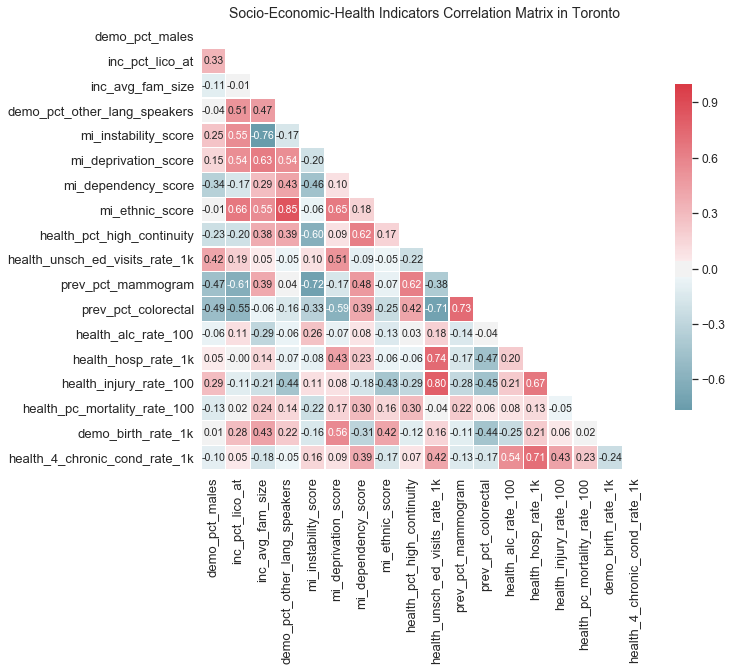

In [8]:
# Correlation Matrix Plot # entire dataset
###############################################################################
# List numerical column names only:
cols =['demo_pct_males', 'inc_pct_lico_at', 'inc_avg_fam_size', 'demo_pct_other_lang_speakers',
'mi_instability_score', 'mi_deprivation_score', 'mi_dependency_score', 'mi_ethnic_score',
'health_pct_high_continuity', 'health_unsch_ed_visits_rate_1k', 'prev_pct_mammogram',
'prev_pct_colorectal', 'health_alc_rate_100', 'health_hosp_rate_1k', 'health_injury_rate_100',
'health_pc_mortality_rate_100', 'demo_birth_rate_1k','health_4_chronic_cond_rate_1k']

# Create a correlation matrix:
cm = df_EDA[cols].corr()

# Create a mask to filter correlation matrix: diagonally
mask = np.zeros_like(cm, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot correlation matrix heatmap
f,ax = plt.subplots(figsize=(10,10))
cmap = sns.diverging_palette(220,10,as_cmap=True)
sns.set(font_scale=1.1)
sns.heatmap(cm, mask=mask, cmap=cmap, fmt='.2f', center=0,
           annot=True, square=True, linewidth=.5,
           annot_kws={'size':10.5}, cbar_kws={'shrink':.6})
plt.xticks(rotation=90, fontsize=13)
plt.yticks(rotation=0, fontsize=13)
plt.title('Socio-Economic-Health Indicators Correlation Matrix in Toronto', fontsize=14)
plt.show()

In [9]:
# Filter the correlation matrix where Pearson's r > 0.6:
for x in cm.columns:
    for y in cm.columns:
        if x < y and cm[x][y] > abs(0.6):
            print(x, y, cm[x][y])

inc_pct_lico_at mi_ethnic_score 0.6593136123341229
inc_avg_fam_size mi_deprivation_score 0.6338865744486404
demo_pct_other_lang_speakers mi_ethnic_score 0.8513881421394249
mi_deprivation_score mi_ethnic_score 0.6488746775620011
health_pct_high_continuity mi_dependency_score 0.6200933161147237
health_pct_high_continuity prev_pct_mammogram 0.6207143193733279
prev_pct_colorectal prev_pct_mammogram 0.727567574027136
health_hosp_rate_1k health_unsch_ed_visits_rate_1k 0.7360266494774005
health_hosp_rate_1k health_injury_rate_100 0.666534019508633
health_injury_rate_100 health_unsch_ed_visits_rate_1k 0.7972957680548597
health_4_chronic_cond_rate_1k health_hosp_rate_1k 0.71107436194997


In [10]:
# Feature Scaling: Standardization
# Step 1: take the numpy matrix of feature(s) as X_cols: values within each column represent the feature.
X_cols = df_new.values

# Step 2: let's apply the feature scaling to standardize the range of values
sc_X = StandardScaler()
X_cols_std = sc_X.fit_transform(X_cols)

# Make a dataframe:
df_new_std = pd.DataFrame(X_cols_std, columns=df_new.columns)
df_new_std.head()

,demo_pct_males,demo_pct_females,inc_pct_lico_at,inc_pct_lim_at,inc_avg_fam_size,inc_pct_econ_no_child,inc_pct_econ_w_child,inc_pct_lone_parents,inc_pct_one_person_house,inc_pct_2more_person_house,...,demo_most_sponken_lang_Russian,demo_most_sponken_lang_Serbian,demo_most_sponken_lang_Somali,demo_most_sponken_lang_Spanish,demo_most_sponken_lang_Tagalog,demo_most_sponken_lang_Tamil,demo_most_sponken_lang_Tibetan,demo_most_sponken_lang_Ukrainian,demo_most_sponken_lang_Urdu,demo_most_sponken_lang_Vietnamese
0,1.160571,-1.160571,-0.472485,-0.477906,1.878281,-1.121727,1.232491,0.003809,-1.266875,1.224147,...,-0.171499,-0.120386,-0.084819,-0.319941,-0.246183,-0.27735,-0.084819,-0.229416,-0.120386,-0.120386
1,0.365292,-0.365292,0.723899,1.048661,2.238587,-1.671863,1.060629,1.229651,-1.486706,1.484809,...,-0.171499,-0.120386,-0.084819,-0.319941,-0.246183,-0.27735,-0.084819,-0.229416,-0.120386,-0.120386
2,0.611696,-0.611696,-0.334366,-0.222381,1.313627,-0.791010,0.565233,0.505567,-1.232568,1.317699,...,-0.171499,-0.120386,-0.084819,-0.319941,-0.246183,-0.27735,-0.084819,-0.229416,-0.120386,-0.120386
3,0.284862,-0.284862,-0.153906,-0.108639,0.560268,-0.840211,0.280031,0.827337,-0.425902,0.507436,...,-0.171499,-0.120386,-0.084819,3.125577,-0.246183,-0.27735,-0.084819,-0.229416,-0.120386,-0.120386
4,0.452388,-0.452388,0.149951,0.470325,1.041280,-1.027432,-0.203629,1.949727,-1.063540,1.043384,...,-0.171499,-0.120386,-0.084819,3.125577,-0.246183,-0.27735,-0.084819,-0.229416,-0.120386,-0.120386


### Uni-variate Analysis: Histogram ###

In [11]:
# Write a function: to plot a histogram with two subplots
def plot_hist(x1,lab1,c1,x2,lab2,c2,bins):
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
    plt.subplots_adjust(hspace=0.9, wspace=0.5)
    # Subplot 1: normal scale
    ax1.hist(df_EDA[x1], bins=bins, color=c1)
    ax1.set_xlabel(lab1)
    ax1.set_ylabel('Number of Neighborhoods')
    ax1.set_title(lab1)
    # Subplot 2: standardized scaled
    ax2.hist(df_EDA[x2], bins=bins, color=c2)
    ax2.set_xlabel(lab2)
    ax2.set_ylabel('Number of Neighborhoods')
    ax2.set_title(lab2)

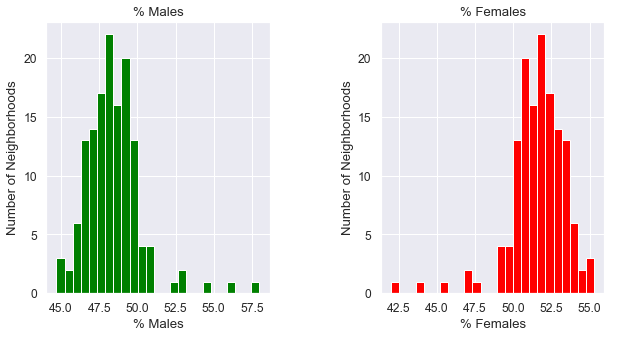

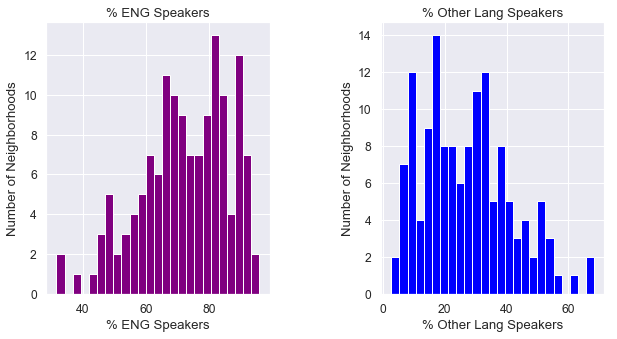

In [12]:
# Histogram Analyses: demographic indicators
plot_hist('demo_pct_males','% Males','green',
          'demo_pct_females','% Females','red',25)
plt.show()

plot_hist('demo_pct_eng_speakers','% ENG Speakers','purple',
          'demo_pct_other_lang_speakers','% Other Lang Speakers','blue',25)
plt.show()

#### Summary: Demographic Indicators ####
1. Male: distribution is skewed to right. Majority of neighbors have male more than 47.5%.
2. Female: distribution is skewed to left. Majority of neighbors have female more than 51%.
3. English Speakers: non-normal distribution. Majority of neighbors have English speakers more than 70%.
4. Other Language Speakers: non-normal distribution. Majority of neighbors have non English speakers more than 30%.

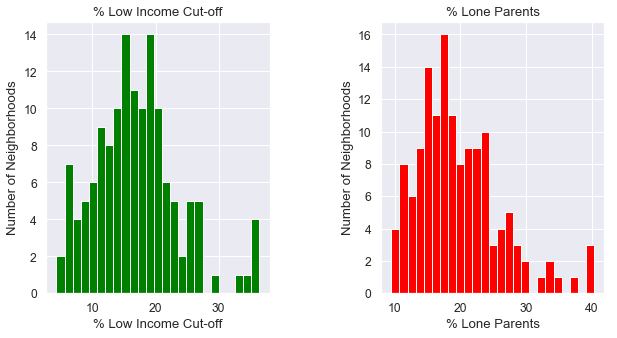

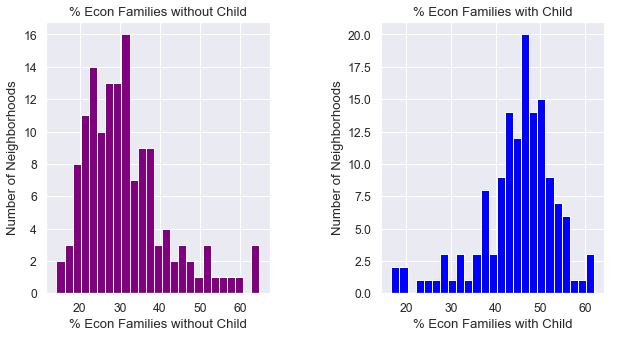

In [13]:
# Histogram Analyses: socio-economic indicators
plot_hist('inc_pct_lico_at','% Low Income Cut-off','green',
          'inc_pct_lone_parents','% Lone Parents','red',25)
plt.show()

plot_hist('inc_pct_econ_no_child','% Econ Families without Child','purple',
          'inc_pct_econ_w_child','% Econ Families with Child','blue',25)
plt.show()

#### Summary: Socio-Economic Income Indicators ####
1. Low Income Cut-off: distribution is close to normal. Majority of neighbors have cut-off at 17%.
2. Lone Parents: distribution is skewed to right. Majority of neighbors have lone parents around 20%.
3. Families without child: distribution is skewed to right. Majority of neighbors have no children at 30%.
4. Families with child: non-normal distribution. Majority of neighbors have children at 45%.

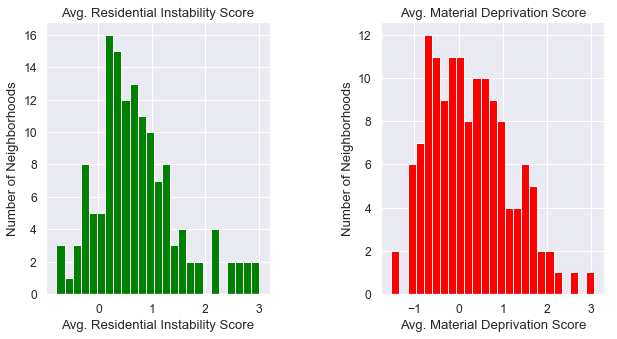

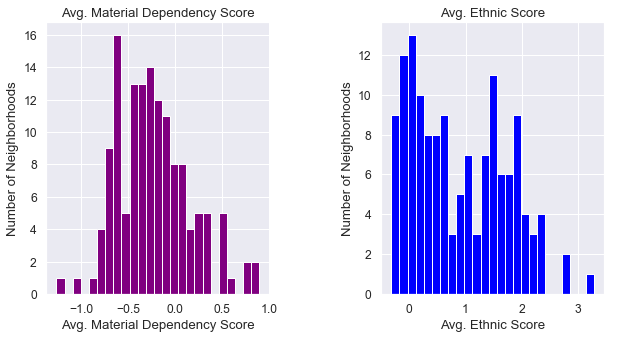

In [14]:
# Histogram Analyses: marginalization index indicators
plot_hist('mi_instability_score','Avg. Residential Instability Score','green',
          'mi_deprivation_score','Avg. Material Deprivation Score','red',25)
plt.show()

plot_hist('mi_dependency_score','Avg. Material Dependency Score','purple',
          'mi_ethnic_score','Avg. Ethnic Score','blue',25)
plt.show()

#### Summary: Marginalization Index Indicators ####
1. Residential Instability: distribution is skewed to right. Majority of neighbors have instability score at 0.7 (middle).
2. Material Deprivation: distribution is skewed to right. Majority of neighbors have deprivation score at 0.25 (low end).
3. Material Dependency: distribution is skewed to right. Majority of neighbors have dependency score at -0.25 (middle).
4. Ethnicity: non-normal distribution. Majority of neighbors have ethnicity score at 1 (middle).

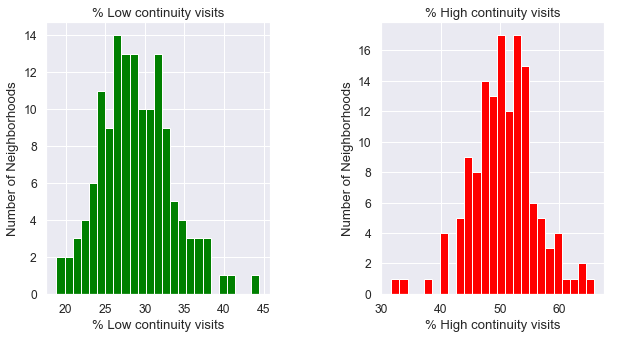

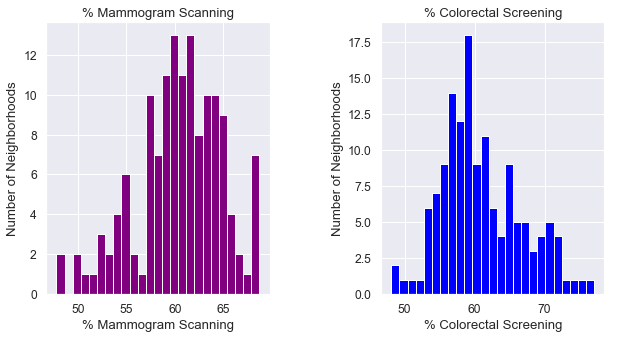

In [15]:
# Histogram Analyses: health & prevention indicators
plot_hist('health_pct_low_continuity','% Low continuity visits','green',
          'health_pct_high_continuity','% High continuity visits','red',25)
plt.show()

plot_hist('prev_pct_mammogram','% Mammogram Scanning','purple',
          'prev_pct_colorectal','% Colorectal Screening','blue',25)
plt.show()

#### Summary: Health Prevention/Screening Indicators ####
1. Low continuity visits: approximated normal distribution. Majority of neighbors have low continuity visits to Community Health Centre at 30%.
2. High continuity visits: approximated normal distribution. Majority of neighbors have high continuity visits to Community Health Centre at 50%.
3. Mammogram scanning: distribution is skewed to left. Majority of neighbors have mammogram scanning at 60%.
4. Colorectal screening: distribution is skewed to right. Majority of neighbors have colorectal screening at 60%.

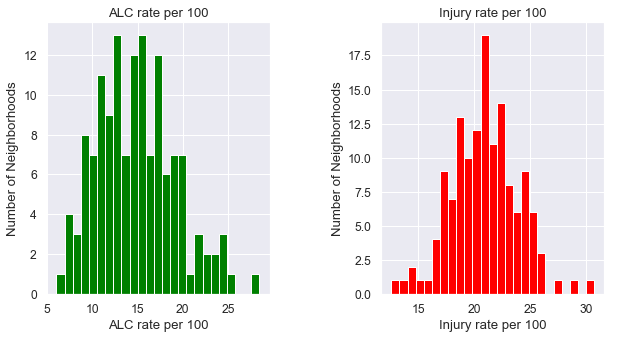

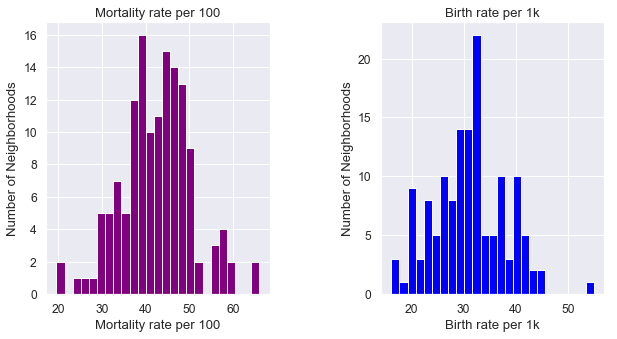

In [16]:
# Histogram Analyses: health monitoring indicators
plot_hist('health_alc_rate_100','ALC rate per 100','green',
          'health_injury_rate_100','Injury rate per 100','red',25)
plt.show()

plot_hist('health_pc_mortality_rate_100','Mortality rate per 100','purple',
          'demo_birth_rate_1k','Birth rate per 1k','blue',25)
plt.show()

#### Summary: Health Indicators Group Rate 1 ####
1. ALC rate per 100: approximated normal distribution. Majority of neighbors have ALC rate at 15.
2. Injury rate per 100: approximated normal distribution. Majority of neighbors have injury rate at 21.
3. Mortality rate per 100: non-normal distribution. Majority of neighbors have mortality rate at 42.
4. Birth rate per 1k: distribution is skewed to right. Majority of neighbors have birth rate at 31.

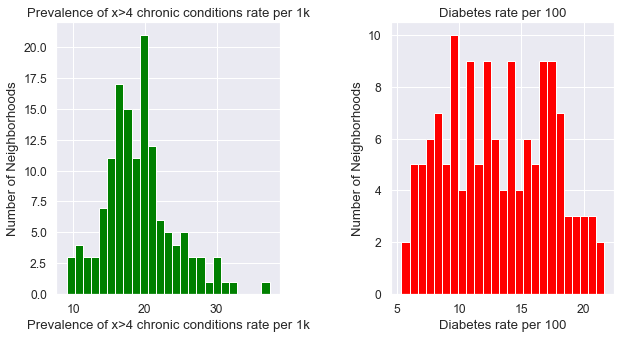

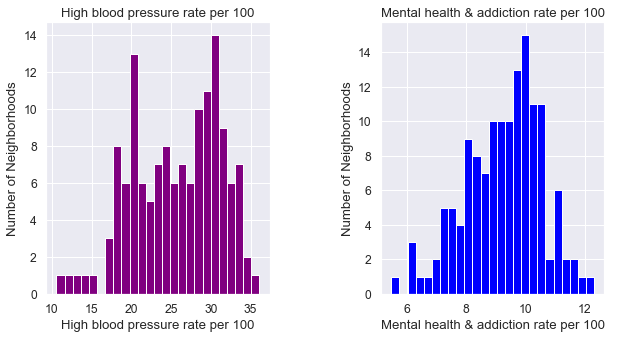

In [17]:
# Histogram Analyses: chronic illness rate indicators
plot_hist('health_4_chronic_cond_rate_1k','Prevalence of x>4 chronic conditions rate per 1k','green',
          'health_diabetes_rate_100','Diabetes rate per 100','red',25)
plt.show()

plot_hist('health_hbp_rate_100','High blood pressure rate per 100','purple',
          'health_mh_rate_100','Mental health & addiction rate per 100','blue',25)
plt.show()

#### Summary: Health Indicators Group Rate 2 ####
1. More than 4 chronic conditions rate per 1k: approximated normal distribution. Majority of neighbors have rate at 19.
2. Diabetes rate per 100: non-normal distribution. Majority of neighbors have diabetes rate at 13.
3. High blood pressure rate per 100: distribution is skewed to left. Majority of neighbors have mortality rate at 26.
4. Mental health/addiction rate per 1k: distribution is skewed to left. Majority of neighbors have birth rate at 9.

## K-Means Clustering ##

[[ 1.16057055 -1.16057055 -0.47248505 ... -0.22941573 -0.12038585
  -0.12038585]
 [ 0.36529172 -0.36529172  0.72389946 ... -0.22941573 -0.12038585
  -0.12038585]
 [ 0.61169562 -0.61169562 -0.33436553 ... -0.22941573 -0.12038585
  -0.12038585]
 ...
 [-0.68255236  0.68255236  0.54763587 ... -0.22941573 -0.12038585
  -0.12038585]
 [-0.3025219   0.3025219   1.3404732  ... -0.22941573 -0.12038585
  -0.12038585]
 [-0.96740804  0.96740804 -1.51912101 ... -0.22941573 -0.12038585
  -0.12038585]]


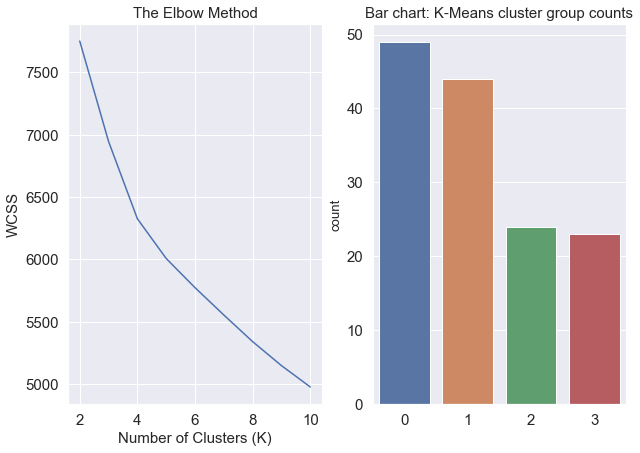

In [18]:
# Print the standardized table matrix:
print(X_cols_std)

# Apply the K-Means cluster:
wcss=[]
for i in range(2,11):
    km = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    km.fit(X_cols_std)
    wcss.append(km.inertia_)
    
# Construct the Elbow method plot:
plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plt.plot(range(2,11), wcss)
plt.title('The Elbow Method', fontsize=15)
plt.xlabel('Number of Clusters (K)', fontsize=15)
plt.ylabel('WCSS', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Fit K-Means cluster with the optimal K=4:
km = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
y_km = km.fit_predict(X_cols_std)
# Plot a bar chart: show number of points in each cluster
plt.subplot(1,2,2)
sns.countplot(y_km)
plt.title('Bar chart: K-Means cluster group counts', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## Choosing the optimal K: The Silhouette Method ##
From the elbow method, it is hard to distinguish the optimal point where changes in WCSS is not so significant.
Therefore, we are going to apply the Silhouette method for assessing the optimal # of clusters. Silhouette score is computed on every single data point in every cluster. The Silhouette score ranges from -1 to +1 to indicate the level of reasonable groupings/structures.

n_clusters =  2 silhouette_avg_score 0.13919226867690543
n_clusters =  3 silhouette_avg_score 0.1353597665451171
n_clusters =  4 silhouette_avg_score 0.1377669275434942
n_clusters =  5 silhouette_avg_score 0.11440928835324904
n_clusters =  6 silhouette_avg_score 0.13308792861230836
n_clusters =  7 silhouette_avg_score 0.1269050709041292
n_clusters =  8 silhouette_avg_score 0.1310856799372231
n_clusters =  9 silhouette_avg_score 0.12949058652459344
n_clusters =  10 silhouette_avg_score 0.13915160285324216


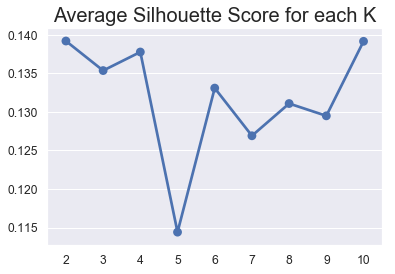

In [19]:
# Compute the Silhouette score for optimal K assessment:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

# Range of clusters: from 2 to 10;
rang_clust = list(range(2,11)) 
silhouette_scores = []

for n_clust in rang_clust:
    km = KMeans(n_clusters=n_clust, init='k-means++', random_state=0)
    km_labels = km.fit_predict(X_cols_std) #X_cols
    
    silhouette_avg = silhouette_score(X_cols_std, km_labels)
    silhouette_scores.append(silhouette_avg)
    print("n_clusters = ", n_clust,
         "silhouette_avg_score", silhouette_avg)

# Plot for average Silhouette score for each "K" cluster(s):
plt.figure()
plt.title('Average Silhouette Score for each K', fontsize=20)
sns.pointplot(x=rang_clust, y=silhouette_scores)
plt.show()

The optimal # of clusters (K=2) based on the given avg. score of silhouette (0.1392). Thus, Toronto Community Health Profile can be segmented based on two different neighborhood groups.

For n_clusters = 2 The average silhouette_score is: 0.13919226867690543


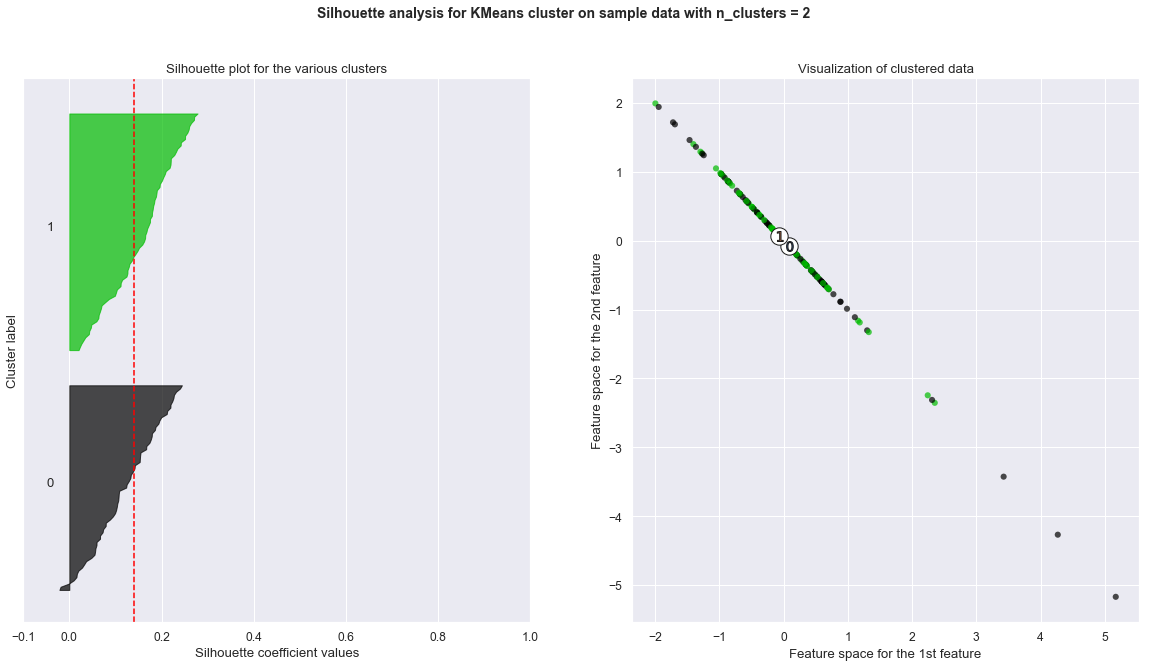

For n_clusters = 3 The average silhouette_score is: 0.1353597665451171


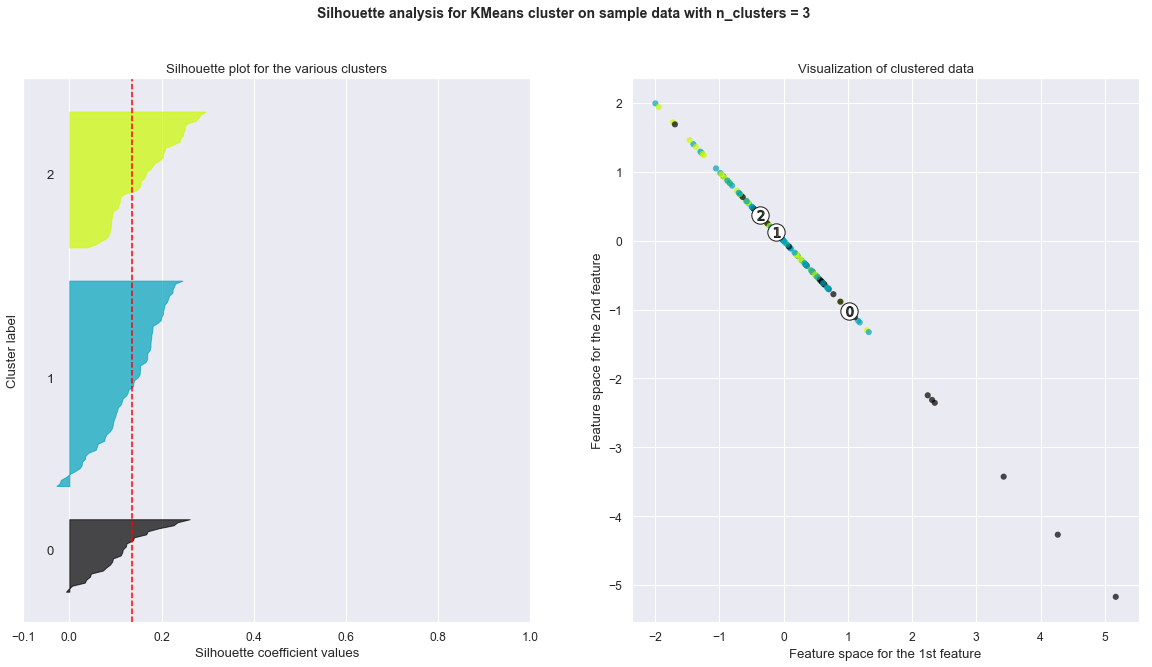

For n_clusters = 4 The average silhouette_score is: 0.1377669275434942


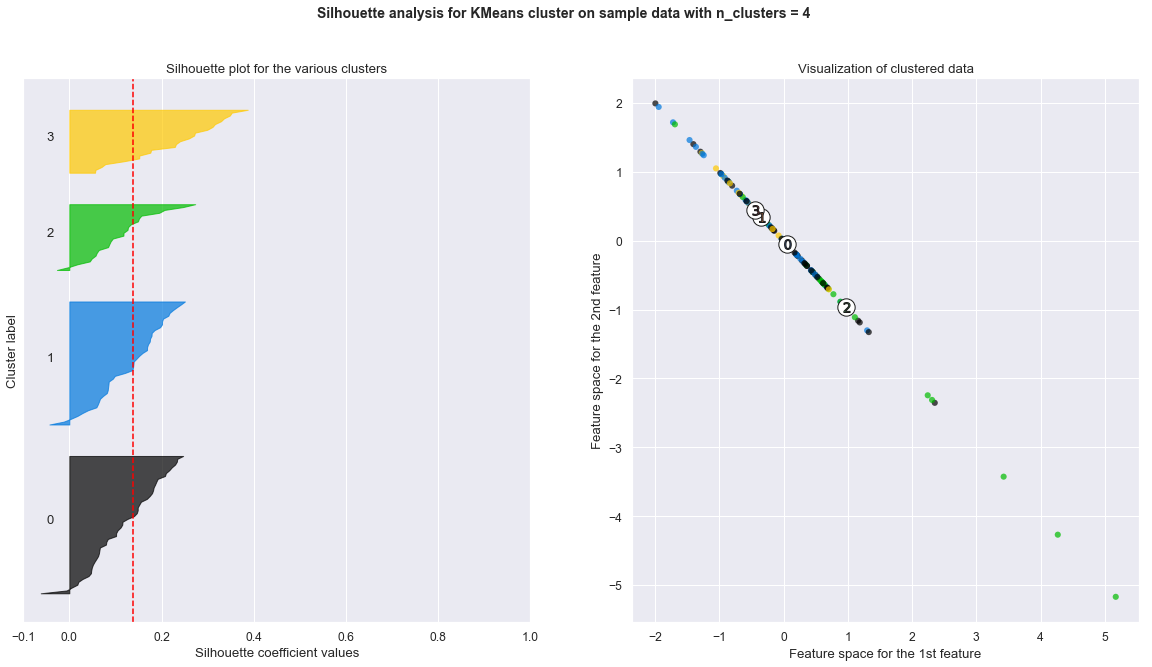

In [20]:
# Reduced range of clusters:
rang_clust = list(range(2,5)) 

# Silhouette and cluster plots for n_clusters:
for n_clust in rang_clust:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(20,10)
    
    # 1st sub-plot: Silhouette plot
    ax1.set_xlim([-0.1, 1])
    # Insert blank space between Silhouette plots: each cluster
    ax1.set_ylim([0, len(X_cols_std) + (n_clust + 1)*10])
    
    # Initialize the cluster with n_clust and a random number generator:
    km = KMeans(n_clusters=n_clust, init='k-means++', random_state=0)
    km_labels = km.fit_predict(X_cols_std)
    
    # Silhouette_score shows the average value: density and separation of formed cluster(s)
    silhouette_avg = silhouette_score(X_cols_std, km_labels)
    print("For n_clusters =", n_clust,
         "The average silhouette_score is:", silhouette_avg)
    
    # Compute the silhouette score for each sample:
    sample_silhouette_values = silhouette_samples(X_cols_std, km_labels)
    
    y_lower = 10
    for i in range(n_clust):
        # Aggreate the silhouette scores for samples belonging to
        # cluster i and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[km_labels == i]
        
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.spectral(float(i) / n_clust)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 
                          0, ith_cluster_silhouette_values,
                         facecolor=color, edgecolor=color, alpha=0.7)
        
        # Label the silhouette plots with their cluster numbers in the middle:
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        
        # Compute the new y_lwoer for next plot
        y_lower = y_upper + 10 # 10 for the 0 samples;
    
    ax1.set_title('Silhouette plot for the various clusters')
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster label')
    
    # The vertical line for avrage silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color='red', linestyle='--')
    
    ax1.set_yticks([]) # clear the y-axis labels/ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    # 2nd plot showing the actual formed clusters
    colors = cm.spectral(km_labels.astype(float) / n_clust)
    ax2.scatter(X_cols_std[:,0], X_cols_std[:,1], marker='.', s=150, lw=0, alpha=0.7, c=colors, edgecolor='k')
    
    # Labeling the clusters
    centers = km.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:,0], centers[:,1], marker='o',
               c='white', alpha=1, s=300, edgecolor='k')
    
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                   s=100, edgecolor='k')
        
    ax2.set_title('Visualization of clustered data')
    ax2.set_xlabel('Feature space for the 1st feature')
    ax2.set_ylabel('Feature space for the 2nd feature')
    
    plt.suptitle(('Silhouette analysis for KMeans cluster on sample data '
                'with n_clusters = %d' % n_clust),
               fontsize=14, fontweight='bold')
    plt.show()   

## Hierarchical Clustering ##

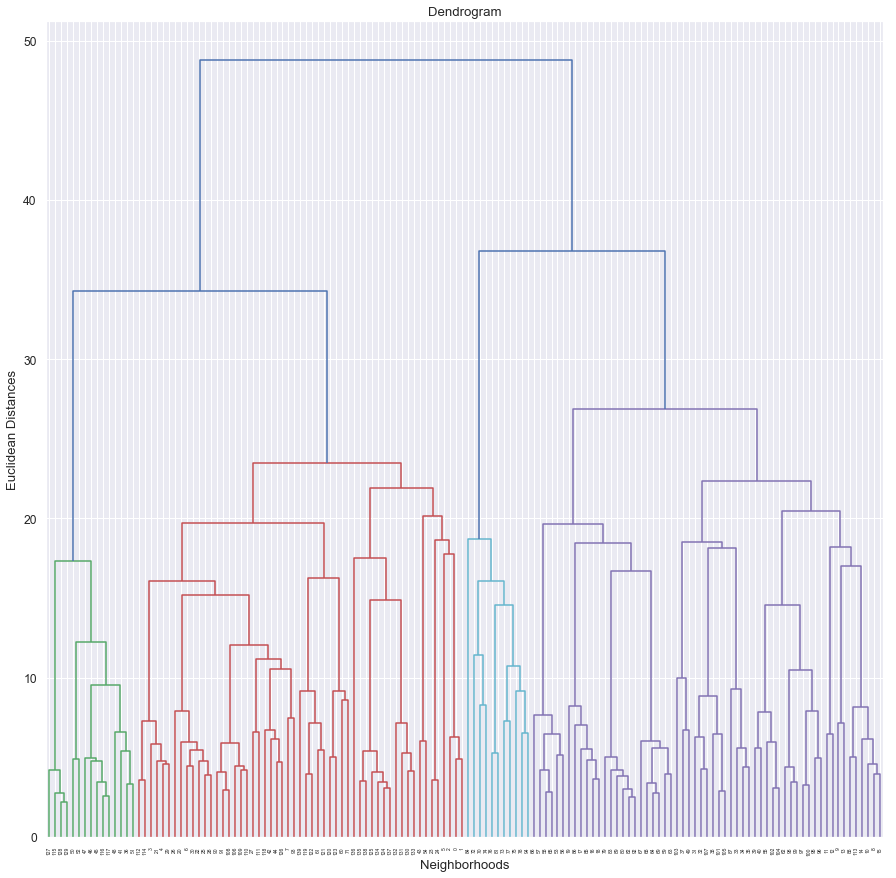

In [21]:
# Step 1: using the dendograms to find the optimal number of clusters (K)
import scipy.cluster.hierarchy as sch
fig = plt.figure(figsize=(15,15))
dn = sch.dendrogram(sch.linkage(X_cols_std, method = 'ward')) 
plt.title ('Dendrogram')
plt.xlabel('Neighborhoods')
plt.ylabel('Euclidean Distances')
plt.show() 

In [22]:
# Step 2: fitting hierarchical clustering to the dataset
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(X_cols_std)

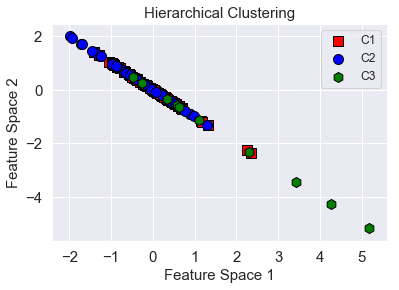

In [23]:
# Step 3: visualizing the clusters 
plt.scatter(X_cols_std[y_hc == 0, 0], 
            X_cols_std[y_hc == 0, 1], 
            s = 100, c = 'red', 
            marker='s', edgecolor='black',
            label = 'C1')
plt.scatter(X_cols_std[y_hc == 1, 0], 
            X_cols_std[y_hc == 1, 1], 
            s = 100, c = 'blue', 
            marker='o', edgecolor='black',
            label = 'C2')
plt.scatter(X_cols_std[y_hc == 2, 0], 
            X_cols_std[y_hc == 2, 1], 
            s = 100, c = 'green', 
            marker='h', edgecolor='black',
            label = 'C3')
#plt.scatter(X_cols_std[y_hc == 3, 0], 
#            X_cols_std[y_hc == 3, 1], 
#            s = 100, c = 'magenta', 
#            marker='h', edgecolor='black',
#            label = 'C4')
plt.title('Hierarchical Clustering', fontsize=15)
plt.xlabel('Feature Space 1', fontsize=15)
xt = plt.xticks(fontsize=15)        
plt.ylabel('Feature Space 2', fontsize=15)
yt = plt.yticks(fontsize=15)
plt.legend()
plt.show()

## Visualize Clusters using PCA: K-Means ##
We have about 140 neighborhoods (data points) each containing 66 features (dimensions). Principal Component Analysis (PCA) will help us avoid the curse of dimensionality by reducing dimensions into a few dimensions (i.e., 2-D). 

In [24]:
# Apply PCA decomposition into 2 components:
pca = PCA(n_components=2) # specify into 2 components
X_cols_pca = pca.fit_transform(X_cols_std) # fit and transform into PCA components

## Choosing Optimal K: Silhouette Method on K-Means with PCA Analysis ##

n_clusters =  2 silhouette_avg_score 0.36714694220573024
n_clusters =  3 silhouette_avg_score 0.38215549881237465
n_clusters =  4 silhouette_avg_score 0.39239737147847303
n_clusters =  5 silhouette_avg_score 0.38736290131555073
n_clusters =  6 silhouette_avg_score 0.40177146521532314
n_clusters =  7 silhouette_avg_score 0.3949379542628517
n_clusters =  8 silhouette_avg_score 0.35957883640177885
n_clusters =  9 silhouette_avg_score 0.3633471502159243
n_clusters =  10 silhouette_avg_score 0.3629371113411936


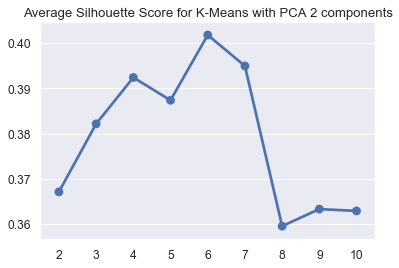

In [25]:
# Compute the Silhouette score for K-Means on PCA reduced dimensions (X & Y)
range_clust_pca = list(range(2,11))
silhouette_scores_pca = []

for n_clust in range_clust_pca:
    km = KMeans(n_clusters=n_clust, init='k-means++', random_state=0)
    km_pca_labels = km.fit_predict(X_cols_pca) # PCA component of X features (2 components)
    
    silhouette_avg_pca = silhouette_score(X_cols_pca, km_pca_labels)
    silhouette_scores_pca.append(silhouette_avg_pca)
    print("n_clusters = ", n_clust,
          "silhouette_avg_score", silhouette_avg_pca)

# Plot for average silhouette score for each "K" clusters transformed by PCA:
plt.figure()
plt.title('Average Silhouette Score for K-Means with PCA 2 components')
sns.pointplot(x=range_clust_pca, y=silhouette_scores_pca)
plt.show()    

The optimal # of clusters (K=6) based on the given avg. score of silhouette (0.4018). Thus, Toronto community profile can be segmented based on six different neighborhood groups.

In [26]:
# Apply K-Means clustering: PCA
km_pca = KMeans(n_clusters=6, init='k-means++', random_state=0).fit(X_cols_pca)
km_pca_labels = km_pca.labels_

# Create a PCA decomposed reduced dimensions and named two components:x, y
df_pca = pd.DataFrame(X_cols_pca)
df_pca.columns = ['X','Y']
df_pca.head()

,X,Y
0,-3.674015,1.447246
1,-4.112593,4.522216
2,-3.375898,2.757807
3,-1.700004,1.638334
4,-1.672826,3.489731


In [27]:
# Create a merged DataFrame: neighborhood name and label
df_merged = df_pca.merge(df['nh_name'].reset_index(), left_index=True, right_index=True).drop('index', axis=1)
# Bind predicted cluster label column:
df_merged['label'] = km_pca_labels
# Print the dataframe:
df_merged.head()

,X,Y,nh_name,label
0,-3.674015,1.447246,West Humber-Clairville,2
1,-4.112593,4.522216,Mount Olive-Silverstone-Jamestown,2
2,-3.375898,2.757807,Thistletown-Beaumond Heights,2
3,-1.700004,1.638334,Rexdale-Kipling,2
4,-1.672826,3.489731,Elms-Old Rexdale,2


In [28]:
# Write a function: plot the PCA scatter plot
def plot_pca_scatter(x,y,label,df,header):
    plt.figure(figsize=(15,15))
    sns.lmplot(x=x, y=y, hue=label, data=df, fit_reg=False)
    plt.title('PCA Scatter Plot: '+header, fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

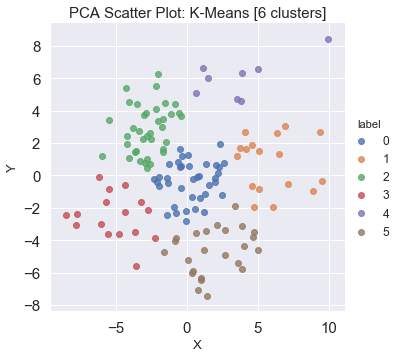

In [29]:
# Visualize the PCA cluster: scatter plot - K-Means 6 clusters
plot_pca_scatter('X','Y','label',df_merged,'K-Means [6 clusters]')

,X,Y,nh_name,label,nh_id,ward_id,ward_name,demo_pct_males,demo_pct_females,inc_pct_lico_at,...,deprivation_status,dependency_status,ethnic_status,lico_at_grp_label,ed_visits_grp_label,alc_rate_grp_label,hosp_rate_grp_label,injury_rate_grp_label,birth_rate_grp_label,chronic_4_cond_rate_grp_label
0,-3.674015,1.447246,West Humber-Clairville,1,1,2,Etobicoke North,0.505515,0.494485,0.137462,...,4-somewhat deprived,3-neutral dependent,5-most ethnic concentrated,Wealthy,Low,Low,Medium,Low,Medium,Low
1,-4.112593,4.522216,Mount Olive-Silverstone-Jamestown,1,2,1,Etobicoke North,0.490776,0.509224,0.217822,...,5-most deprived,2-little dependent,5-most ethnic concentrated,Neutral,Medium,Low,Medium,Low,High,Low
2,-3.375898,2.757807,Thistletown-Beaumond Heights,1,3,1,Etobicoke North,0.495343,0.504657,0.146739,...,5-most deprived,5-most dependent,4-somewhat ethnic concentrated,Wealthy,Medium,Medium,High,Medium,Medium,Medium
3,-1.700004,1.638334,Rexdale-Kipling,1,4,2,Etobicoke North,0.489285,0.510715,0.158860,...,4-somewhat deprived,4-somewhat dependent,3-neutral ethnic concentrated,Neutral,Medium,Low,High,Medium,Medium,Medium
4,-1.672826,3.489731,Elms-Old Rexdale,1,5,2,Etobicoke North,0.492390,0.507610,0.179270,...,5-most deprived,2-little dependent,4-somewhat ethnic concentrated,Neutral,Medium,Low,High,Medium,Medium,Low


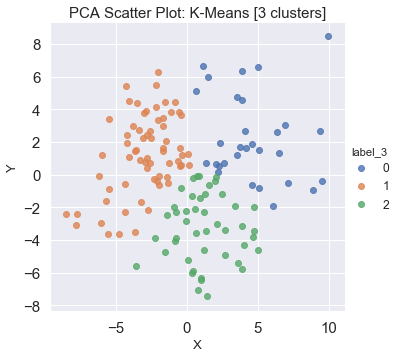

In [30]:
# Re-fit K-Means using 3 clusters:
df_merged['label_3'] = KMeans(n_clusters=3, init='k-means++', random_state=0).fit(X_cols_pca).labels_
# Visualize the PCA cluster: scatter plot - K-Means 3 clusters
plot_pca_scatter('X','Y','label_3',df_merged,'K-Means [3 clusters]')

# Assume 3 clusters: label = label_3
df_merged['label'] = df_merged['label_3']
df_merged = df_merged.drop(['label_3'], axis=1)

# Reviewed the clustered data points by merge with other community health profile features:
df_review = df_merged.merge(df, on='nh_name')
df_review.head()

## Visualize Clusters using PCA: Hierarchical ##

In [31]:
# Apply Hierarchical clustering: PCA
hc_pca = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
hc_pca_labels = hc.fit_predict(X_cols_pca)

# Create a merged DataFrame: neighborhood name and label - Hierarchical Clustering
df_merged_hc = df_pca.merge(df['nh_name'].reset_index(), left_index=True, right_index=True).drop('index', axis=1)
# Bind predicted cluster label column:
df_merged_hc['label'] = hc_pca_labels
# Print the dataframe:
df_merged_hc.head()

,X,Y,nh_name,label
0,-3.674015,1.447246,West Humber-Clairville,0
1,-4.112593,4.522216,Mount Olive-Silverstone-Jamestown,0
2,-3.375898,2.757807,Thistletown-Beaumond Heights,0
3,-1.700004,1.638334,Rexdale-Kipling,0
4,-1.672826,3.489731,Elms-Old Rexdale,0


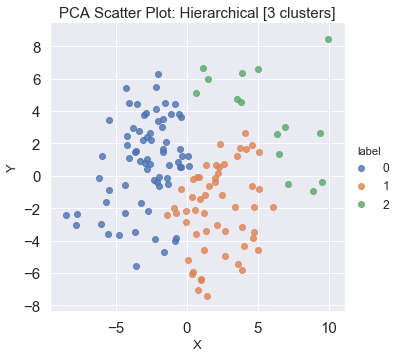

In [32]:
# Visualize the PCA cluster: scatter plot - Hierarchical 3 clusters
plot_pca_scatter('X','Y','label',df_merged_hc,'Hierarchical [3 clusters]')

,X,Y,nh_name,label,nh_id,ward_id,ward_name,demo_pct_males,demo_pct_females,inc_pct_lico_at,...,deprivation_status,dependency_status,ethnic_status,lico_at_grp_label,ed_visits_grp_label,alc_rate_grp_label,hosp_rate_grp_label,injury_rate_grp_label,birth_rate_grp_label,chronic_4_cond_rate_grp_label
0,-3.674015,1.447246,West Humber-Clairville,1,1,2,Etobicoke North,0.505515,0.494485,0.137462,...,4-somewhat deprived,3-neutral dependent,5-most ethnic concentrated,Wealthy,Low,Low,Medium,Low,Medium,Low
1,-4.112593,4.522216,Mount Olive-Silverstone-Jamestown,1,2,1,Etobicoke North,0.490776,0.509224,0.217822,...,5-most deprived,2-little dependent,5-most ethnic concentrated,Neutral,Medium,Low,Medium,Low,High,Low
2,-3.375898,2.757807,Thistletown-Beaumond Heights,1,3,1,Etobicoke North,0.495343,0.504657,0.146739,...,5-most deprived,5-most dependent,4-somewhat ethnic concentrated,Wealthy,Medium,Medium,High,Medium,Medium,Medium
3,-1.700004,1.638334,Rexdale-Kipling,1,4,2,Etobicoke North,0.489285,0.510715,0.158860,...,4-somewhat deprived,4-somewhat dependent,3-neutral ethnic concentrated,Neutral,Medium,Low,High,Medium,Medium,Medium
4,-1.672826,3.489731,Elms-Old Rexdale,1,5,2,Etobicoke North,0.492390,0.507610,0.179270,...,5-most deprived,2-little dependent,4-somewhat ethnic concentrated,Neutral,Medium,Low,High,Medium,Medium,Low


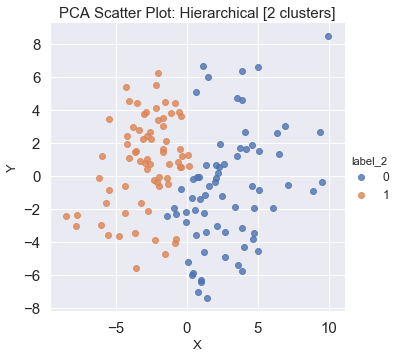

In [33]:
# Re-fit the Hierarchical cluster using 2 clusters:
df_merged_hc['label_2'] = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'ward').fit_predict(X_cols_pca)
# Visualize the PCA cluster: scatter plot - Hierarchical 2 clusters
plot_pca_scatter('X','Y','label_2',df_merged_hc,'Hierarchical [2 clusters]')

# Assume 2 clusters: label = label_2
df_merged_hc['label'] = df_merged_hc['label_2']
df_merged_hc = df_merged_hc.drop(['label_2'], axis=1)

# Reviewed the clustered data points by merge with other community health profile features:
df_review_hc = df_merged_hc.merge(df, on='nh_name')
df_review_hc.head()

## Visualization: Biplot ##
A biplot is a scatterplot where each data point is represented by its scores along the principal components. The axes are the PCA (dim 1 and dim 2). In addition, the biplot shows the projection of the original reduced features along the components. It helps us to explore relationships between the principal components and original features.

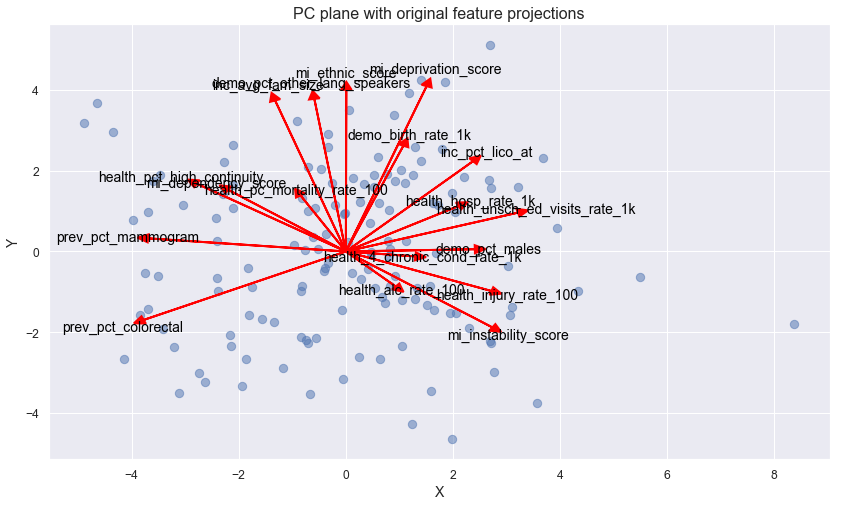

In [34]:
def biplot(good_data, reduced_data, pca):
    '''
    Produce a biplot that shows a scatterplot of the reduced
    data and the projections of the original features.
    
    good_data: original data, before transformation.
               Needs to be a pandas dataframe with valid column names

reduced_data: the reduced data (the first two dimensions are plotted)
    pca: pca object that contains the components_ attribute
    return: a matplotlib AxesSubplot object (for any additional customization)
    
    https://github.com/teddyroland/python-biplot
    '''

    fig, ax = plt.subplots(figsize = (14,8))
    # scatterplot of the reduced data    
    ax.scatter(x=reduced_data.loc[:, 'X'], y=reduced_data.loc[:, 'Y'], 
        facecolors='b', edgecolors='b', s=70, alpha=0.5)
    
    feature_vectors = pca.components_.T

    # we use scaling factors to make the arrows easier to see
    arrow_size, text_pos = 9.5, 10.5,

    # projections of the original features
    for i, v in enumerate(feature_vectors):
        ax.arrow(0, 0, arrow_size*v[0], arrow_size*v[1], 
                  head_width=0.2, head_length=0.2, linewidth=2, color='red')
        ax.text(v[0]*text_pos, v[1]*text_pos, good_data.columns[i], color='black', 
                 ha='center', va='center', fontsize=14)

    ax.set_xlabel("X", fontsize=14)
    ax.set_ylabel("Y", fontsize=14)
    ax.set_title("PC plane with original feature projections", fontsize=16);
    return ax

# Plot the bi-plot with PCA components:
# good_data = standardized dataframe with reduced features
good_data = df_new_std[cols]

# Apply PCA by fitting the good data with 2 dimensions:
pca = PCA(n_components=2) 
pca.fit(good_data)

# reduced_data = PCA applied on good_data (reduced)
reduced_data = pca.transform(good_data)
reduced_data = pd.DataFrame(reduced_data, columns = ['X', 'Y'])

# Create a biplot
biplot(good_data, reduced_data, pca)

### Observation ###
Red arrows show the original feature projections. Thus, it is easier to interpret the relative position of each data point in the biplot. 

Here is the summarized interpretations:
1. ALC rate, injury rate and instability score strongly associated with each other.
2. % high continuity of CHC visits, mortality rate and dependency score strongly associated with each other.
3. Avg. family size, % other language speakers, ethnic score strongly associated with each other.
4. % male population and rate of having more than 4 chronic conditions strongly associated with each other.

## Model Interpretation: Bar Charts on Clustered Data ##

In [35]:
# Write a function to plot: bar charts
def plot_bar_chart(x,y,df,var,label):
    plt.figure(figsize=(20,8))
    sns.countplot(x=x, hue=y, data=df)
    plt.title('Bar Chart: ' + var, fontsize=20)
    plt.xticks(rotation=90, fontsize=20)
    plt.xlabel(label, fontsize=20)
    plt.ylabel('Number of Neighborhoods', fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(loc='upper right', fontsize=20)
    
# Write a function to plot: bar charts by ordinal categorical order
def plot_bar_chart_order(x,y,df,var,label,order):
    plt.figure(figsize=(20,8))
    sns.countplot(x=x, hue=y, data=df, order=order)
    plt.title('Bar Chart: ' + var, fontsize=20)
    plt.xticks(rotation=90, fontsize=20)
    plt.xlabel(label, fontsize=20)
    plt.ylabel('Number of Neighborhoods', fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(loc='upper right', fontsize=20)

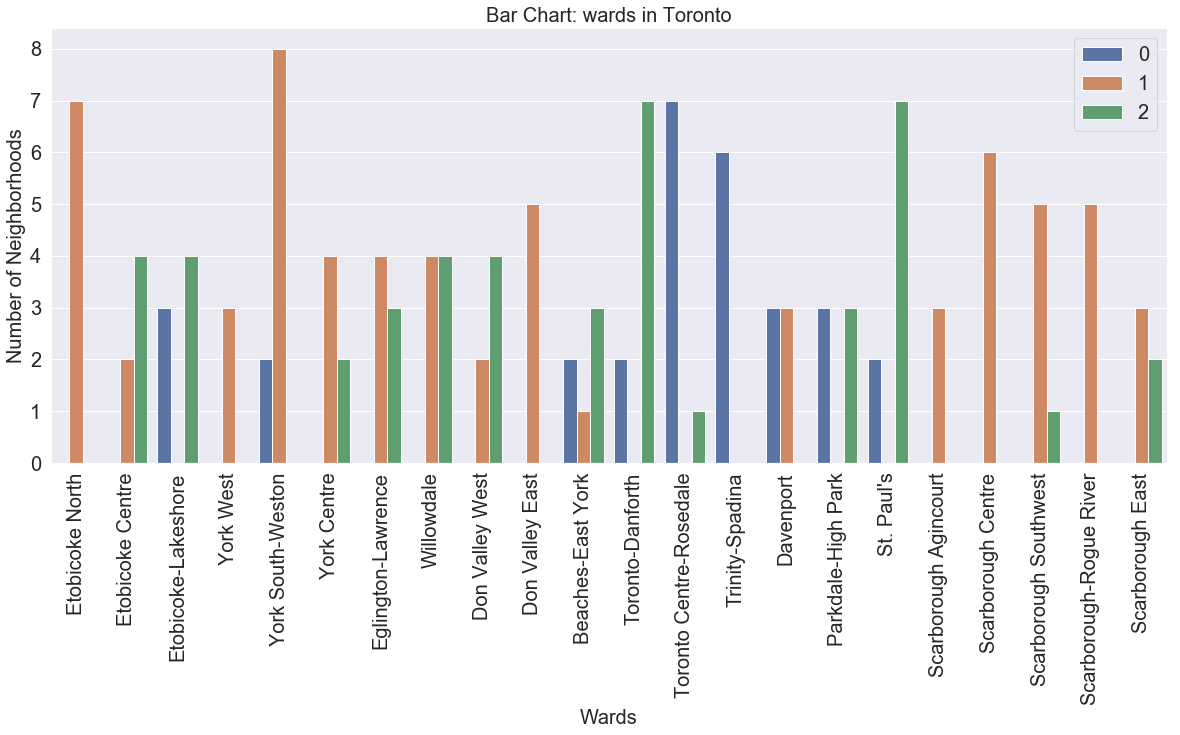

In [36]:
# Plot bar charts on City of Toronto Wards and cluster labels:
plot_bar_chart('ward_name','label', df_review, 'wards in Toronto', 'Wards')
plt.show()

**Bar Chart Interpreation: at ward level in Toronto**

Summary: in Toronto, following # of wards are assigned on each neighborhood group
* group 0 = 8 wards
* group 1 = 16 wards
* group 2 = 13 wards

From the above bar charts, we can draw couple of interesting observations:
* York South-Weston ward was predominant on neighborhood group 1 and small # of neighborhood group 0.
* Toronto-Danforth ward was predominant on neighborhood group 2 and no neighborhood groups of 0 and 1.
* Toronto Centre-Rosedale ward was predominant on neighborhood group 0 followed by neighborhood group 2.

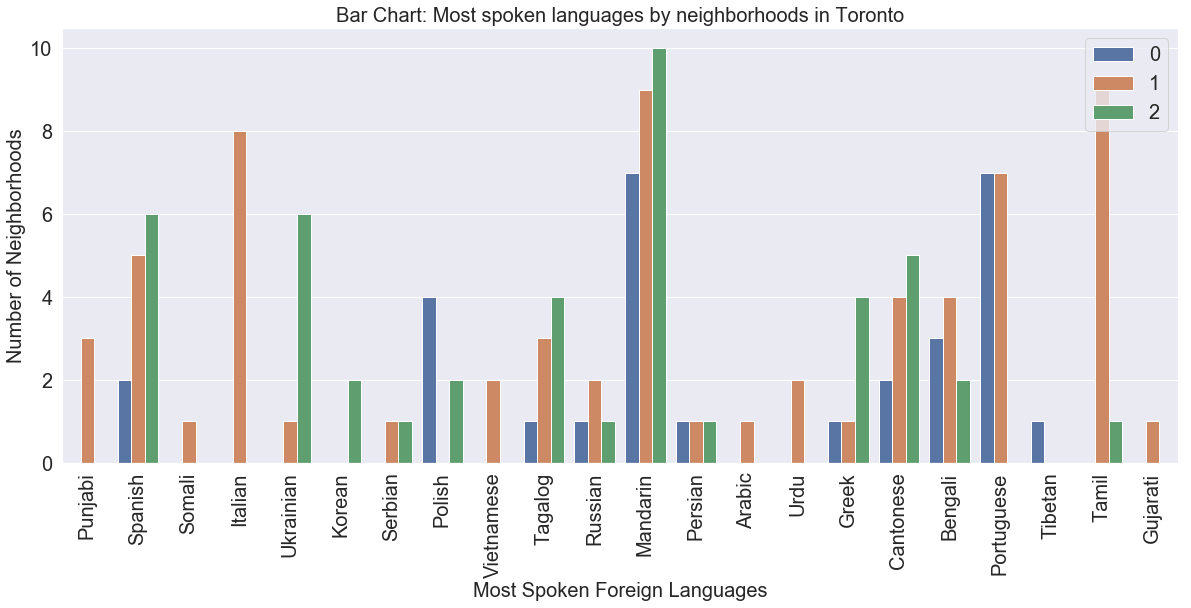

In [37]:
# Plot bar charts on most spoken languages and cluster labels:
plot_bar_chart('demo_most_sponken_lang','label', df_review, 
               'Most spoken languages by neighborhoods in Toronto', 'Most Spoken Foreign Languages')
plt.show()

**Bar Chart Interpreation: most spoken foreign language by neighborhood area(s)**

Note: Mandarin spoken area was predominant in Toronto neighborhoods followed by Tamil, Portuguese, Cantonese, Spanish and etc.
* Mandarin spoken area(s), all three-neighborhood group(s) with label 0, 1 and 2 were found.
* Also Spanish, Cantonese, Bengali, Tagalog, etc. spoken area(s) had neighborhoods with all 3 labels.
* Tibetan spoken area(s) had only neighborhood group(s) with label 0.
* Italian, Urdu, Arabic, Somali and Punjabi spoken area(s) had only neighborhood group(s) with label 1.
* Korean spoken area(s) had only neighborhood group with label 2.

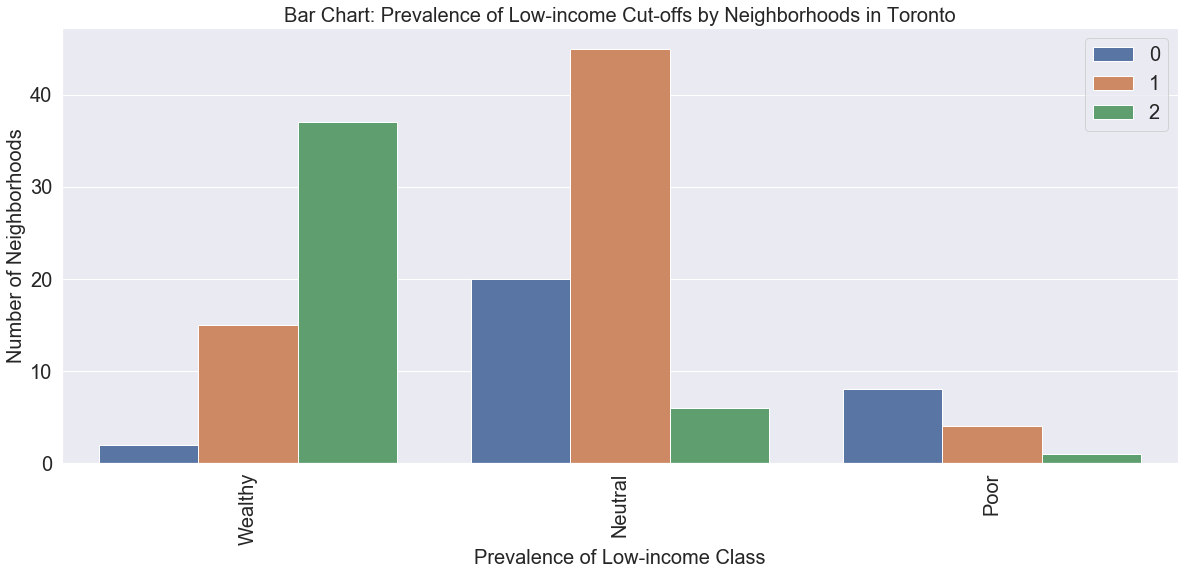

In [38]:
# Plot bar charts on % of low-income cut-off after tax and cluster labels:
plot_bar_chart('lico_at_grp_label','label', df_review, 
               'Prevalence of Low-income Cut-offs by Neighborhoods in Toronto', 'Prevalence of Low-income Class')
plt.show()

**Bar Chart Interpreation: prevalence of low income based on the low-income cut-offs after tax groups**
* Neighborhood group with label 0 has the highest prevalence of low income based on neighborhood counts [relative poor].
* Neighborhood group with label 1 has neutral level - prevalence of low income based on neighborhood counts [relative middle].
* Neighborhood group with label 2 has the lowest prevalence of low income based on neighborhood counts [relative wealthy].

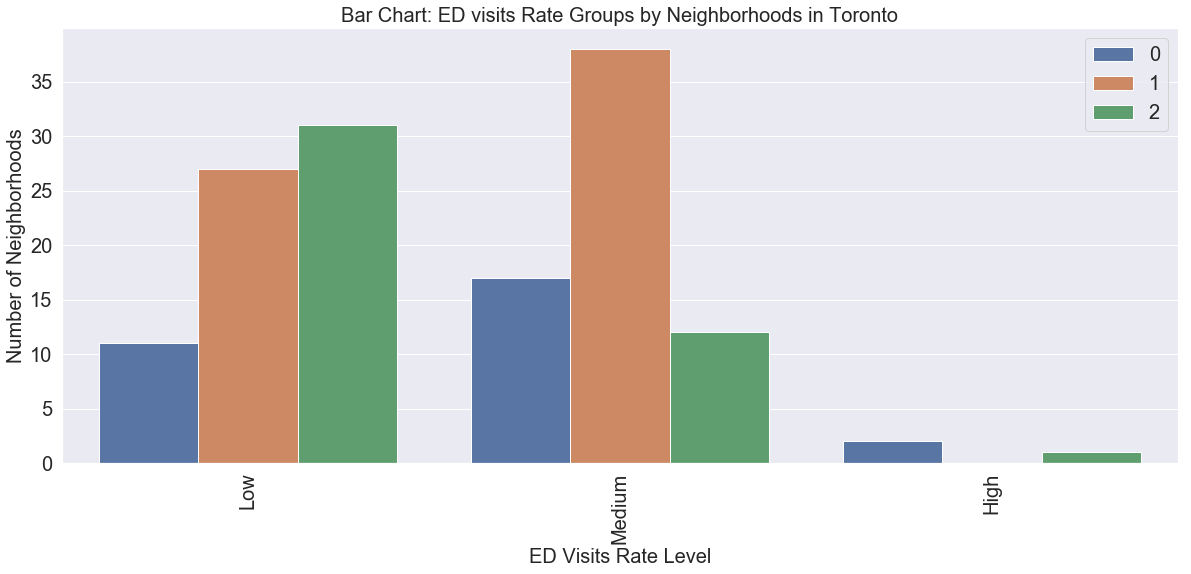

In [39]:
# Plot bar charts on  and cluster labels:
plot_bar_chart('ed_visits_grp_label','label', df_review, 
               'ED visits Rate Groups by Neighborhoods in Toronto', 'ED Visits Rate Level')

**Bar Chart Interpreation: unscheduled ED visits rate per 1000 groups**
* Neighborhood group with label 0 has the highest count of high ED visits rate followed by label 2 [high ED visits].
* Neighborhood group with label 1 has the highest count of medium ED visits rate [medium ED visits]
* Neighborhood group with label 2 has the highest count of low ED visits rate followed by label 1 [low ED visits].

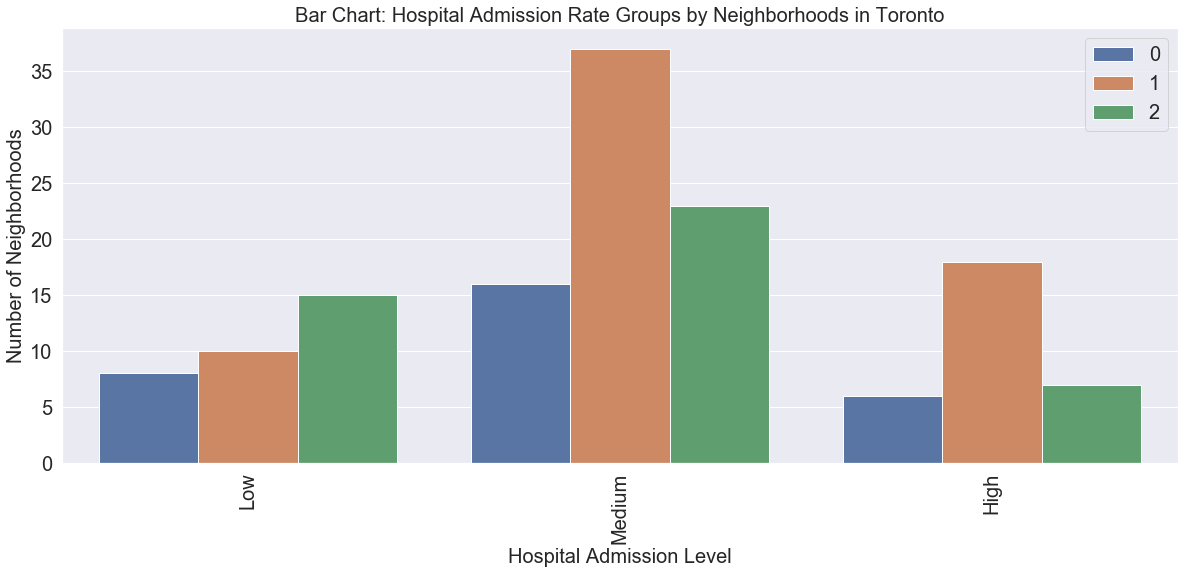

In [40]:
# Plot bar charts on and cluster labels:
plot_bar_chart('hosp_rate_grp_label','label', df_review, 
               'Hospital Admission Rate Groups by Neighborhoods in Toronto', 'Hospital Admission Level')

**Bar Chart Interpreation: hospital admission rate per 1000 groups**
* Neighborhood group with label 0 has lower counts of hospital admissions across all hospital admission levels.
* Neighborhood group with label 1 has the highest count of high and medium hospital admissions among 3 labels.
* Neighborhood group with label 2 has the highest count of low hospital admissions among 3 group labels.

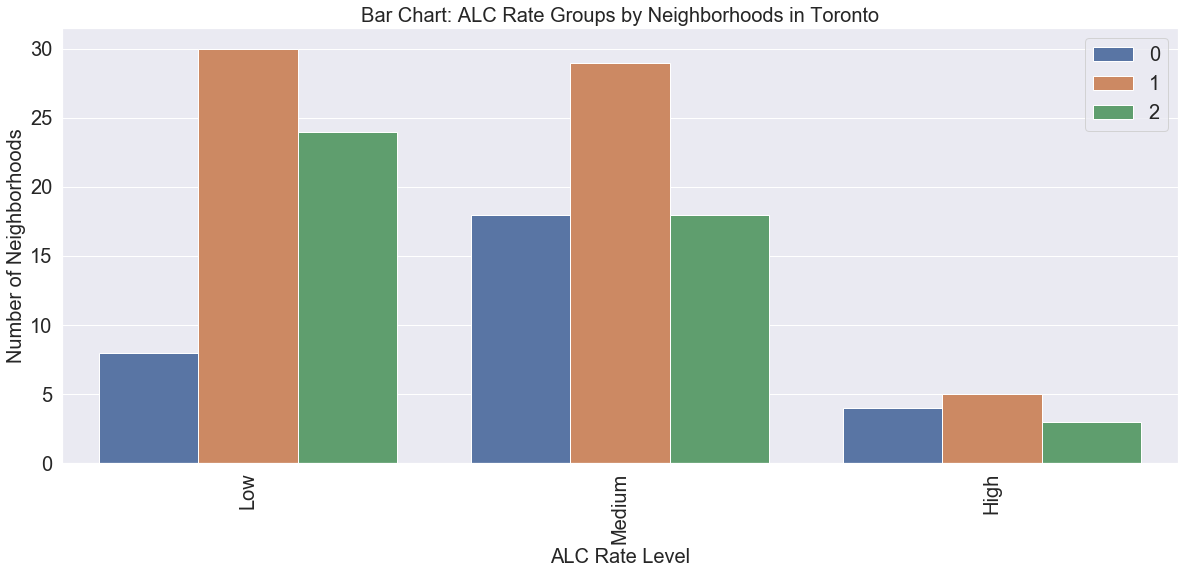

In [41]:
# Plot bar charts on and cluster labels:
plot_bar_chart('alc_rate_grp_label','label', df_review, 
               'ALC Rate Groups by Neighborhoods in Toronto', 'ALC Rate Level')

**Bar Chart Interpreation: Alternative Level of Care rate per 100 groups**
* Neighborhood group with label 0 has the highest count of medium ALC rate across the 3 different ALC rate levels.
* Neighborhood group with label 1 has the highest count of low ALC rate across the 3 different ALC rate levels.
* Neighborhood group with label 1 has the highest count of high ALC rate among 3 neighborhood groups.
* Neighborhood group with label 2 has the highest count of low ALC rate followed by medium and high.

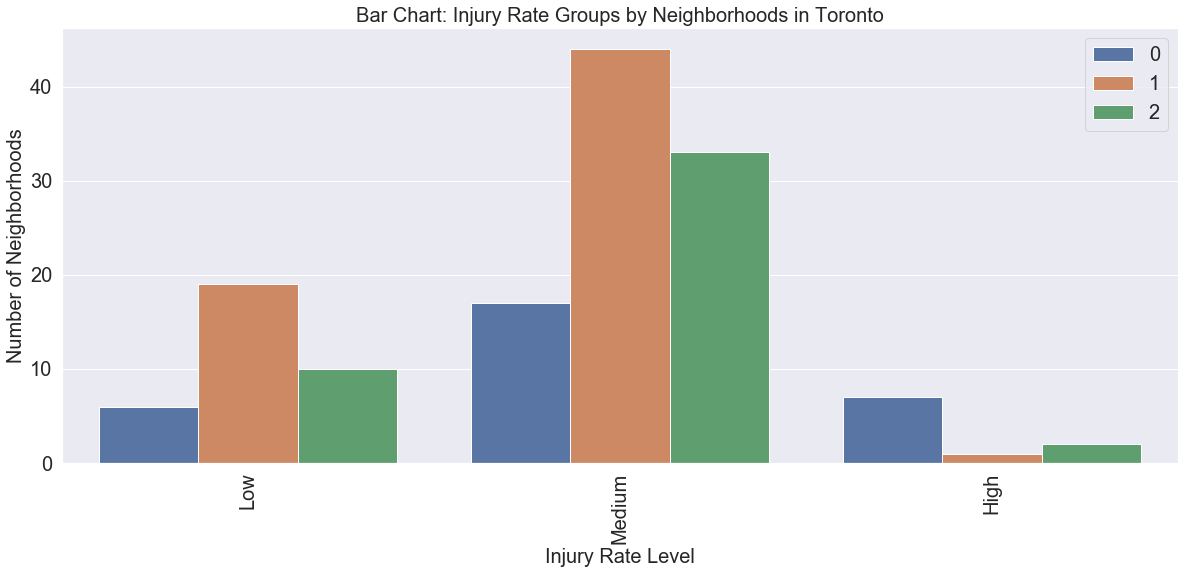

In [42]:
# Plot bar charts on and cluster labels:
plot_bar_chart('injury_rate_grp_label','label', df_review, 
               'Injury Rate Groups by Neighborhoods in Toronto', 'Injury Rate Level')

**Bar Chart Interpreation: Injury rate per 100 groups**
* Low injury rate: counts of neighborhood group label 0 < 2 < 1 --> [group 1]
* Medium injury rate: counts of neighborhood group label 0 < 2 < 1 --> [group 1]
* High injury rate: counts of neighborhood group label 1 < 2 < 0 --> [group 0]

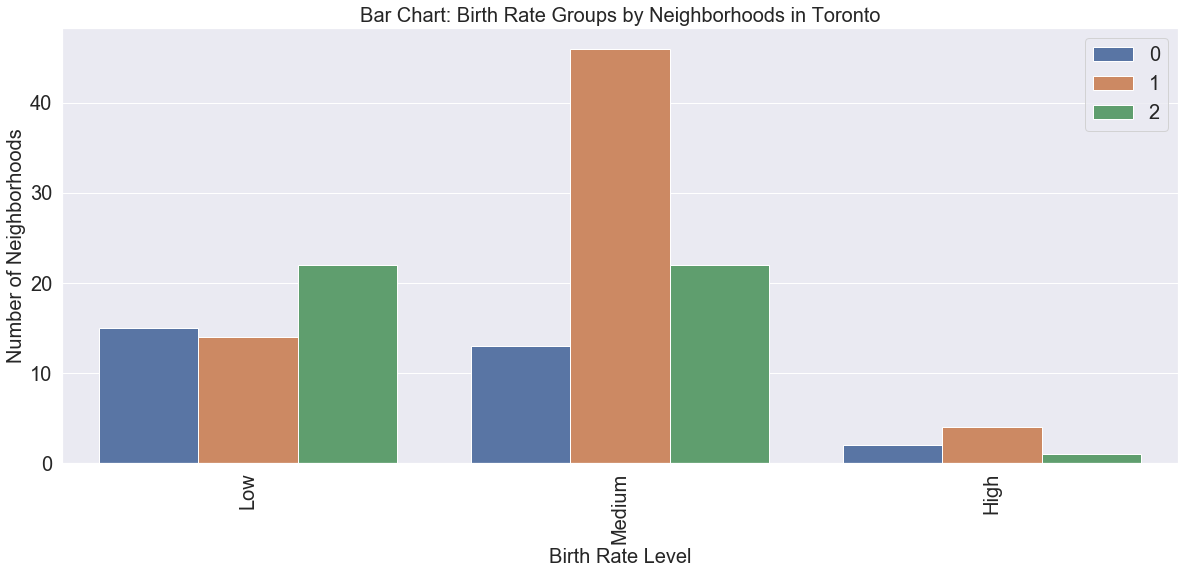

In [43]:
# Plot bar charts on and cluster labels:
plot_bar_chart('birth_rate_grp_label','label', df_review, 
               'Birth Rate Groups by Neighborhoods in Toronto', 'Birth Rate Level')

**Bar Chart Interpreation: Birth rate per 1000, women aged 15-49 groups**
* Low birth rate: counts of neighborhood group label 0 < 1 < 2 --> [group 2] 
* Medium birth rate: counts of neighborhood group label 0 < 2 < 1 --> [group 1] 
* High birth rate: counts of neighborhood group label 2 < 0 < 1 --> [group 1] 

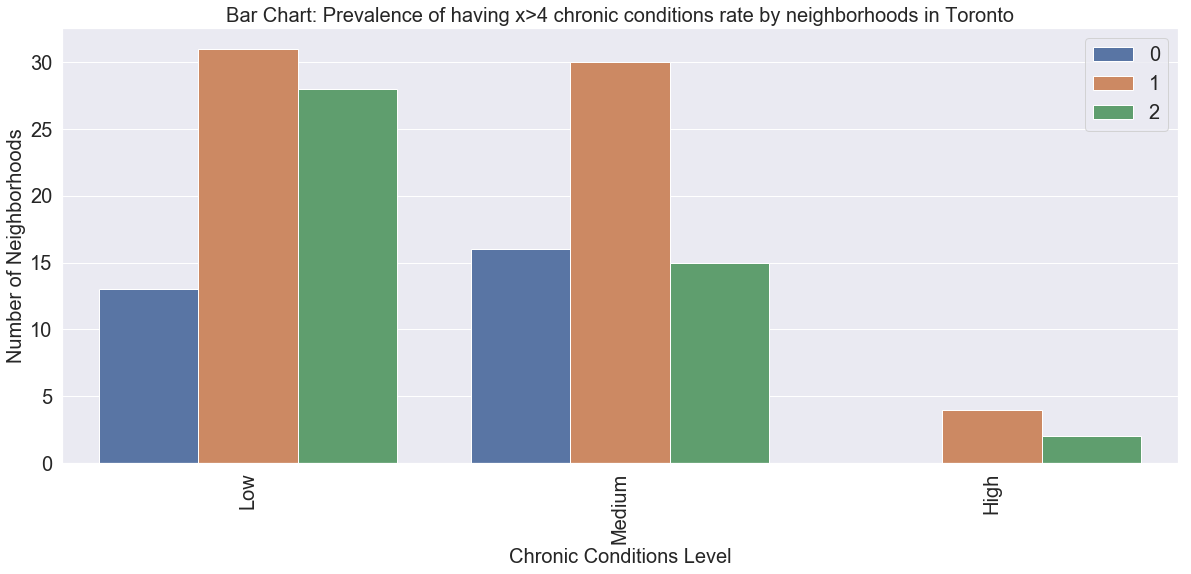

In [44]:
# Plot bar charts on  and cluster labels:
plot_bar_chart('chronic_4_cond_rate_grp_label','label', df_review, 
               'Prevalence of having x>4 chronic conditions rate by neighborhoods in Toronto', 'Chronic Conditions Level')

**Bar Chart Interpreation: prevalence of having more than 4 chronic conditions rate per 1000**
* Neighborhood group with label 1 has the highest count for medium prevalence of having more than 4 chronic conditions across different chronic condition levels [somewhat unhealthy].
* Neighborhood group with label 2 has the highest count for low prevalence of having more than 4 chronic conditions across different chronic condition levels [healthy].
* Neighborhood group with label 0 has the highest count for medium prevalence of having more than 4 chronic conditions across different chronic condition levels [somewhat unhealthy].

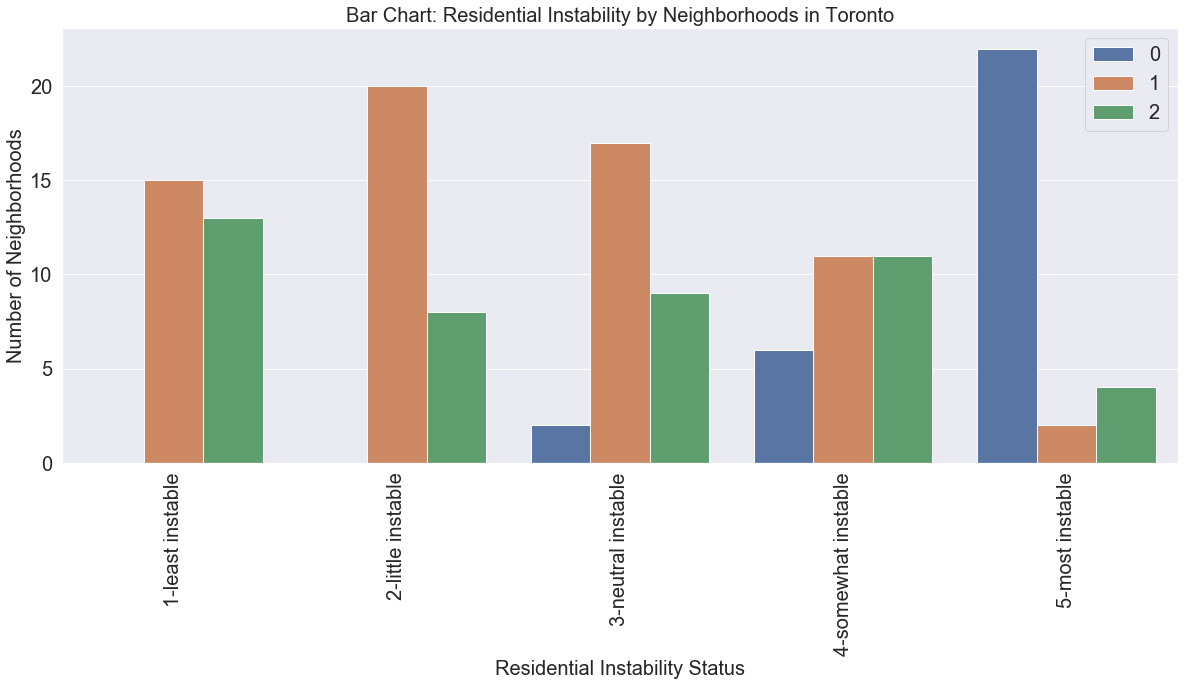

In [45]:
# Plot bar charts on residential instability and cluster labels:
plot_bar_chart_order('instability_status','label', df_review, 'Residential Instability by Neighborhoods in Toronto',
                     'Residential Instability Status', order=['1-least instable', '2-little instable',
                     '3-neutral instable', '4-somewhat instable', '5-most instable'])
plt.show()

**Bar Chart Interpreation: residential instability groups in Toronto**
* Neighborhood group label 0 represents areas where people most likely to experience family or housing instability problems.
* Neighborhood groups with label 1 and 2 represent areas where people least likely to experience family or housing instability problems.

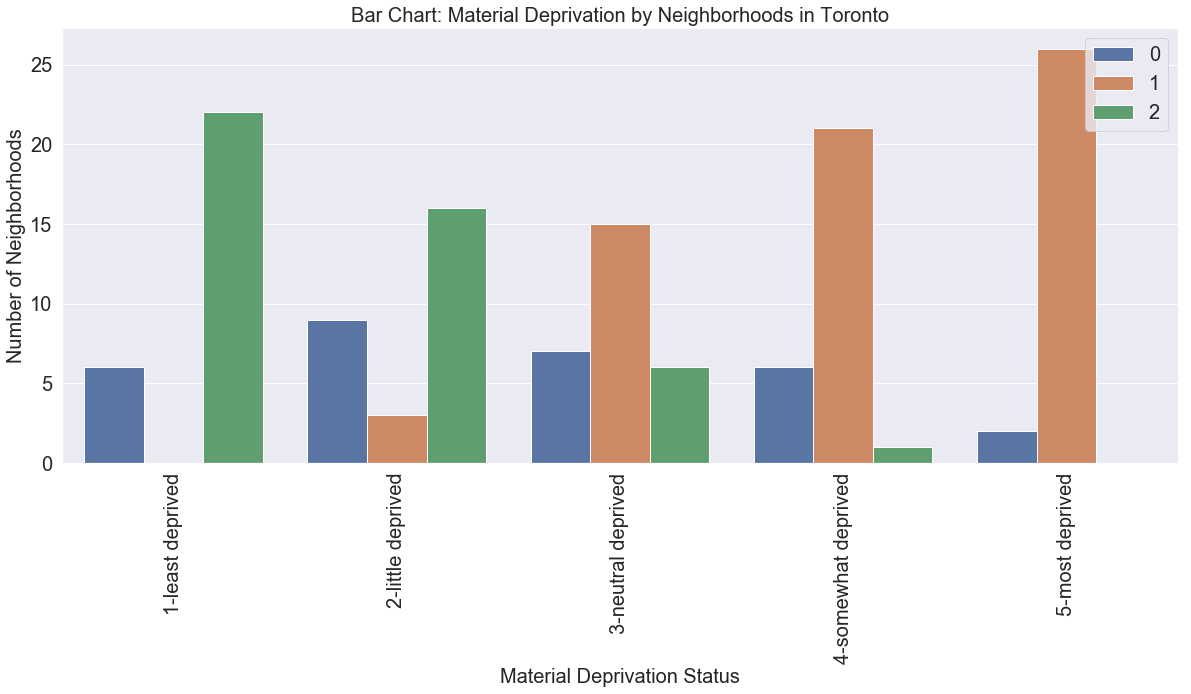

In [46]:
# Plot bar charts on material deprivation and cluster labels:
plot_bar_chart_order('deprivation_status','label', df_review, 'Material Deprivation by Neighborhoods in Toronto',
                     'Material Deprivation Status', order=['1-least deprived', '2-little deprived',
                     '3-neutral deprived','4-somewhat deprived','5-most deprived'])
plt.show()

**Bar Chart Interpreation: material deprivation groups in Toronto**
* Neighborhood groups with label 0 represent areas where people experience neutral poverty (inability to access basic needs: food, income and education).
* Neighborhood groups with label 1 represent areas where people most likely to experience poverty (inability to access basic needs: food, income and education).
* Neighborhood groups with label 2 represent areas where people least likely to experience poverty (inability to access basic needs: food, income and education).

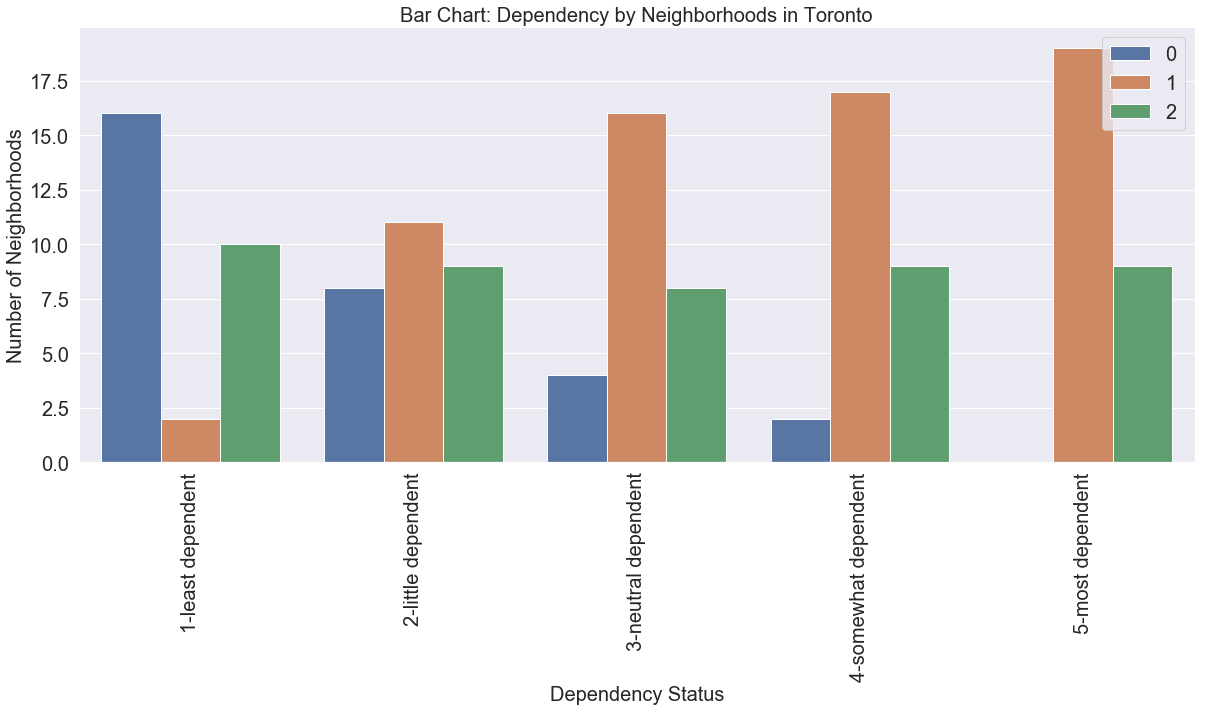

In [47]:
# Plot bar charts on dependency and cluster labels:
plot_bar_chart_order('dependency_status','label', df_review, 'Dependency by Neighborhoods in Toronto', 
                     'Dependency Status', order=['1-least dependent', '2-little dependent','3-neutral dependent',
                     '4-somewhat dependent', '5-most dependent'])
plt.show()

**Bar Chart Interpreation: dependency groups in Toronto**
* Neighborhood group with label 0 account for areas where people being the least dependent on subsidies (i.e., do not have income from employment).
* Neighborhood group with label 1 account for areas where people being the most dependent on subsidies (i.e., do not have income from employment).
* Neighborhood group with label 2 account for areas where people being somewhat dependent on subsidies (i.e., do not have income from employment).

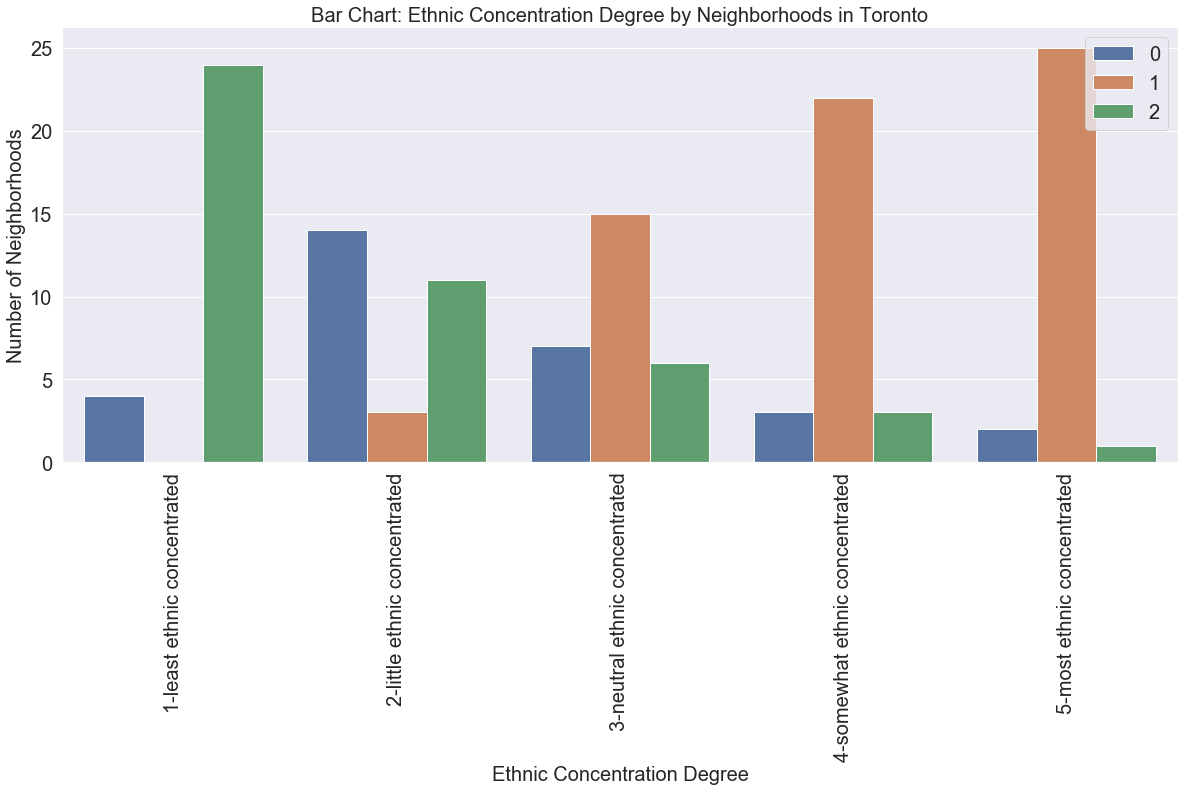

In [48]:
# Plot bar charts on ethnic concentration and cluster labels:
plot_bar_chart_order('ethnic_status','label', df_review, 'Ethnic Concentration Degree by Neighborhoods in Toronto',
                     'Ethnic Concentration Degree', order=['1-least ethnic concentrated', '2-little ethnic concentrated',
                     '3-neutral ethnic concentrated','4-somewhat ethnic concentrated', '5-most ethnic concentrated'])
plt.show()

**Bar Chart Interpreation: ethnic concentration status in Toronto**
* Neighborhood group label 0 represents areas where little to medium degree of immigrants or people belonging to a 'visible minority' group live.
* Neighborhood group label 1 represents areas where the most immigrants or people belonging to a 'visible minority' group live.
* Neighborhood group label 2 represents areas where the least immigrants or people belonging to a 'visible minority' group live.

In [49]:
# Check the lengh of matrix w.r.t: columns
len(X_cols_std[0])

65

## Initialize a new PCA model ##

We are going to used the explained variance component to plot the optimal # of clusters determined by PCA model!

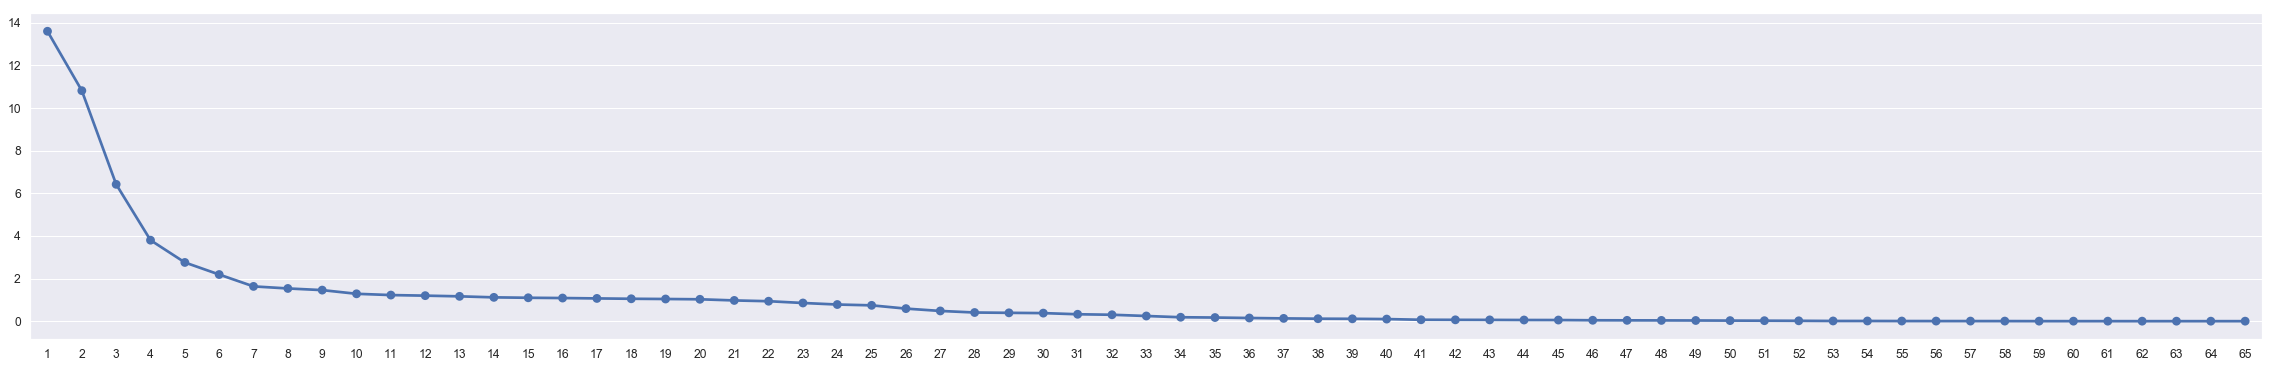

In [50]:
# Initialize: new PCA model
pca = sklearn.decomposition.PCA()
pca.fit(X_cols_std)

# Compute the explained variance
pca.explained_variance_

# Plot a explained variance:
plt.figure(figsize=(40,6))
sns.pointplot(x=list(range(1,66)), y=pca.explained_variance_)

From the above explained variance plot, optimum elbow point for # of pca components seems n=4. Thus, PCA algorithm suggests that the optimal number of components should be 4.